# Figures for my MA
1. Map study area 
2. upwelling season mean
    - plot with 4 panels for (a) Ek, (b) SST, (c) SLP and (d) SSH 
3. Upwelling season trend
    - plot with 4 panels for (a) Ek, (b) SST, (c) SLP and (d) SSH
4. UIs 
    - (a) UI<sub>Ek</sub> and (b) UI<sub>SST</sub>
5. UIs long
    - (a) UI<sub>Ek</sub> and (b) UI<sub>SST</sub>
6. Correlation UI<sub>SST</sub> and UI<sub>Ek</sub>
7. Correlation NAO
8. Extremes timeline
9. Composties

## Supllementary Material
1. Angle $\varphi$ relative to coast? 
2. Monthly means of Vars
    - Ek, SST, SLP and SSH
3. SST at 15° W and mid-shelf
4. Upwelling season trend SST zoom in
5. Upwelling season trend SLP extended
6. Composite plots bottom 10% of events

In [1]:
## save figs
save_var = True

## Import packages and data

In [2]:
## import packages
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
import matplotlib.dates as dates
import matplotlib.patheffects as path_effects
import cmasher as cmr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import my_functions
from scipy.stats import linregress
from scipy.stats import pearsonr
from scipy import stats
import cmocean.cm as cmo
from shapely.geometry import LineString, MultiLineString
%matplotlib inline

In [3]:
## import data
os.chdir('/Users/marie-louisekorte/Documents/Uni Leipzig/Lisbon/Data.nosync/')
MTSS = xr.open_dataset('MTSS_weekly.nc')
SST = xr.open_dataset('CoRTAD_weekly.nc')
SSH = xr.open_dataset('SSH_weekly.nc') # SSH IBI
SLP = xr.open_dataset('SLP_weekly.nc')
Angles = xr.open_dataset('Angles_coast.nc')
# mid-shelf coordinates
mid_shelf_lat = np.genfromtxt('Mid-shelf/lat_midshelf_CoRTAD.dat')[:,1]
mid_shelf_lon = np.genfromtxt('Mid-shelf/lon_midshelf_CoRTAD.dat')[:,1]
# batymetry (https://download.gebco.net)
bathymetry = xr.open_dataset('Bathymetry/gebco_2024_n45.0_s35.0_w-20.0_e-5.0.nc')

In [4]:
## set dir where I want to save my figures
os.chdir('/Users/marie-louisekorte/Documents/Uni Leipzig/Lisbon/Iberian_Coast_Upwelling/Figures/Report/')

## Data Prep

In [5]:
## selct common period MTSS, SLP and SST
MTSS = MTSS.sel(time = slice('01/01/1982', '31/12/2022'))
SLP = SLP.sel(time = slice('01/01/1982', '31/12/2022'))
SST = SST.sel(time = slice('01/01/1982', '31/12/2022'))

In [6]:
## exclude area with lakes from SST data
mask = xr.where((SST.lat >= 38) & (SST.lat <= 43) & (SST.lon >= -8) & (SST.lon <= -5), 0, 1)
SST['lake_mask'] = mask.astype('bool') # area I want to keep = 1, lake and land I want to exclude = 0
SST = SST.where(SST.lake_mask, drop = True)

In [7]:
## calculate the UIs (and add mid_shelf mask)
# UI Ek (here near shore directly ... no longer using the 'simplified' 10.5°W version
Ek = MTSS
Ek = my_functions.calc_upwelling_index(MTSS, MTSS.lat, MTSS.lon, MTSS.metss.where(MTSS.lsm), MTSS.mntss.where(MTSS.lsm), near_shore = True, angles = Angles.angle_phi)
Ek = my_functions.add_mid_shelf(Ek, mid_shelf_lat, mid_shelf_lon)
Ek = Ek.drop_vars('UI')
Ek['UI'] = Ek.UI_ns 

# UI SST and SSH
SST = my_functions.add_mid_shelf(SST, mid_shelf_lat, mid_shelf_lon)
SST['UI'] = SST.SST.where(SST.lon == -15.019103) - SST.SST.where(SST.mid_shelf).mean(dim = 'lon')
SST.UI.attrs.update({'Name' : 'SST upwelling index', 'Info' : 'SST at 15° - SST at mid-shelf', 'Sign' : 'positive inidcates upwelling'})

In [8]:
## meridional mean 
# choose min 37.25 and max 43°N -> this is where the UI annual mean of the upwelling season mean is positive (except at Setubal 38.25)
Ek['UI_mean'] = Ek.UI.where((Ek.lat >= 37.25) & (Ek.lon <= 43)).mean(dim = ['lat', 'lon'])
SST = my_functions.calc_meridional_mean(SST, lon = -15.019103, min_lat = 37.25, max_lat = 43.5)

In [9]:
## summer subset (i.e. upwelling season)
Ek_summer = my_functions.subset_summer(Ek)
SLP_summer = my_functions.subset_summer(SLP)
SST_summer = my_functions.subset_summer(SST)
SSH_summer = my_functions.subset_summer(SSH)

In [10]:
## upwelling season annual mean (select relevant variables for faster processing)
Ek_summer_mean = Ek_summer[['ek_trans_u', 'ek_trans_v', 'UI', 'UI_mean','lsm']].resample(time = 'YE', label = 'left').mean(dim = 'time')
SLP_summer_mean = SLP_summer[['msl', 'lsm']].resample(time = 'YE', label = 'left').mean(dim = 'time')
SST_summer_mean = SST_summer[['SST', 'UI', 'UI_mean']].resample(time = 'YE', label = 'left').mean(dim = 'time')
SSH_summer_mean = SSH_summer['zos'].resample(time = 'YE', label = 'left').mean(dim = 'time')

## Functions

#### Maps (i.e. Variables / Composites)

In [11]:
## plot map

def plot_map(DS, title = 'Title', cmap = 'coolwarm', vmin = None, vmax = None, cbar_label = 'Label', add_contour = False, save =  save_var, save_fig_as = 'Map', ax = None):
    plt.figure(figsize=(10, 6))
        
    # Set up the map 
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-19, -5.5, 45, 36])
    ax.coastlines()
    gls = ax.gridlines(draw_labels=True, linewidth = 0.5)
    gls.top_labels = False 
    gls.right_labels = False
      
    cp = DS.plot(add_colorbar = False, cmap = cmap, vmin = vmin, vmax = vmax, alpha = 0.8)
    plt.colorbar(cp, ax = ax, label = cbar_label, fraction = 0.046, pad = 0.01);

    if add_contour == True:
        clp = DS.plot.contour(colors = 'black', linewidths = 1, levels = np.arange(1010,1028, 0.25))
        plt.clabel(clp, fontsize = 7)
    
    plt.title(f'{title}')

    if save:
        plt.savefig(f'{save_fig_as}.png', dpi = 300, bbox_inches = 'tight')

    return ax.boxplot(DS)

In [12]:
# plot monthly means
def plot_monthly_means(DS, DS_month, Ek = False, main_title = 'Main Title', title = 'Title', cbar_label = 'lable', cmap = 'None', levels = 'None',
                       ticks = 'None', add_contour = False, save = False, save_fig_as = 'map_monthly_mean'):
    
    xsize = 4 # is actually the number of rows
    ysize = 3 # is the number of collumns
    
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']


    fig, axs = plt.subplots(xsize, ysize, figsize = (12, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    i = 0
    for x in np.arange(0, xsize):
        for y in np.arange(0, ysize):
            
            ax = axs[x, y]
            
            ax.set_extent([-20.01, -4.99, 45.01, 34.99])
            ax.coastlines()
            gls = ax.gridlines(draw_labels=True, linewidth = 0.5)
            gls.top_labels = False 
            gls.right_labels = False

            
            if add_contour:
                clp = DS.where(DS_month == months[i], drop = True).mean(dim = 'time').plot.contour(ax = axs[x, y], 
                                    colors = 'black', linewidths = 1, levels = np.arange(1010,1028, 0.5))
                plt.clabel(clp, fontsize = 7)

            if Ek == False: 
                cp = DS.where(DS_month == months[i], drop = True).mean(dim = 'time').plot.imshow(ax = axs[x, y], extend = 'neither',
                               transform = ccrs.PlateCarree(), add_colorbar = False, levels = levels, cmap = cmap)
            
            if Ek == True:             
                mag = np.hypot(DS.ek_trans_u.where(DS_month == months[i], drop = True).mean(dim = 'time') * 1000, 
                               DS.ek_trans_v.where(DS_month == months[i], drop = True).mean(dim = 'time') * 1000)
                cp = mag.plot.imshow(ax = axs[x, y], transform = ccrs.PlateCarree(), add_colorbar = False, 
                              cmap = cmap, levels = levels, alpha = 0.8)
                im = ax.quiver(DS.lon, DS.lat, DS.ek_trans_u.where(DS_month == months[i], drop = True).mean(dim = 'time') * 1000, 
                               DS.ek_trans_v.where(DS_month == months[i], drop = True).mean(dim = 'time') * 1000, 
                               angles='xy', scale_units='xy', scale = 2 * 1000, clim = [0,1 * 1000]) 
                qk = ax.quiverkey(im, -0.1, 1.09, 1 * 1000, r'1000 $\frac{\rm m^3}{\rm s \ km}$', labelpos='E')
                
            ax.set_title(f'Mean {title} {months[i]}')
            ax.set_xlabel('Longitude [°E]')
            ax.set_ylabel('Latitude [°N]')
    
            i = i + 1

    
    # adjust spacing around subplots (because fig.tight_layout() doesn't work with the method I use to add the colorbar
    plt.subplots_adjust(bottom=1.2, right=1.1, top=1.4)
    
    fig.subplots_adjust(bottom = 0.25)
    cbar_ax = fig.add_axes([0.25, 0.18, 0.7, 0.03])
    if Ek == False:
        fig.colorbar(cp, ticks = ticks, cax=cbar_ax, orientation = 'horizontal', label = cbar_label)
    if Ek == True: 
        fig.colorbar(cp, ticks = np.arange(0, 1100, 100), cax=cbar_ax, orientation = 'horizontal', 
                     label = r'Ekamn transport [$\frac{\rm m^3}{\rm s \ km}$]');

    fig.suptitle(f'{main_title}', x = 0.6, y = 1.47, horizontalalignment = 'center')
    if save == True:
        fig.savefig(f'{save_fig_as}.png', dpi = 300, bbox_inches = 'tight')

In [13]:
# calculate trend
def calc_trend_and_significance(data):
    n_time = data.shape[0]
    x = np.arange(n_time)  # Time indices, assumed to be in consistent units (e.g., years)
    slopes = np.empty((data.shape[1], data.shape[2]))
    p_values = np.empty((data.shape[1], data.shape[2]))
    
    for i in range(data.shape[1]):
        for j in range(data.shape[2]):
            y = data[:, i, j]
            regression = linregress(x, y)
            slopes[i, j] = regression.slope
            p_values[i, j] = regression.pvalue
    return slopes, p_values

#### UIs

In [14]:
## plot variable, give stats over whole period and last decade

def plot_trend(x_dates, y, col = 'darkcyan', title = 'Title', ylabel = 'Y axis', long = False, ax = None, last_decades = True):
    # get values for the trend line analysis
    #fig = plt.figure(figsize = (8, 3))

    # calculate stats whole period
    x = np.arange(len(x_dates))
    regression = linregress(x, y)

    if last_decades == True:
        # define last decades in years and calculate stats
        last_10 = x_dates.dt.isocalendar().year.max().values - 9 # minus nine years because the last year is already fully included 
        x_dates_10 = np.delete(x_dates, (np.where(x_dates.dt.isocalendar().year < last_10)))
        x_10 = np.delete(x, (np.where(x_dates.dt.isocalendar().year < last_10)))
        y_10 = np.delete(y, (np.where(x_dates.dt.isocalendar().year < last_10)))
        regression_10 = linregress(x_10, y_10)
    
        # define second last decades in years and calculate stats
        last_20_min = x_dates.dt.isocalendar().year.max().values - 19  # need to define min and max
        last_20_max = x_dates.dt.isocalendar().year.max().values - 10 
        x_dates_20 = np.delete(x_dates, (np.where((x_dates.dt.isocalendar().year <= last_20_min) | (x_dates.dt.isocalendar().year > last_20_max))))
        x_20 = np.delete(x, (np.where((x_dates.dt.isocalendar().year <= last_20_min) | (x_dates.dt.isocalendar().year > last_20_max))))
        y_20 = np.delete(y, (np.where((x_dates.dt.isocalendar().year <= last_20_min) | (x_dates.dt.isocalendar().year > last_20_max))))
        regression_20 = linregress(x_20, y_20)
    
    # plot 
    # all data
    plt.plot(x_dates, y, marker = '.', markerfacecolor = col, alpha = 0.5, color = col)
    # trend whole period
    plt.plot(x_dates, x*regression.slope + regression.intercept, "k-", alpha = 0.8, lw = 1, 
             label = f'{x_dates.dt.isocalendar().year.min().values+1}-{x_dates.dt.isocalendar().year.max().values+1} \ntrend: {regression.slope:.4f} \np-value: {regression.pvalue:.4f}') 
    
    if last_decades == True:
        # 10 years before that ('second last' decade)
        plt.plot(x_dates_20, x_20*regression_20.slope + regression_20.intercept, "k--", lw = 1, 
                 label = f'{last_20_min+1}-{last_20_max+1} \ntrend: {regression_20.slope:.4f} \np-value: {regression_20.pvalue:.4f} ') 
        # last 10 years
        plt.plot(x_dates_10, x_10*regression_10.slope + regression_10.intercept, "k:", 
                 label = f'{last_10+1}-{x_dates.dt.isocalendar().year.max().values+1} \ntrend: {regression_10.slope:.4f} \np-value: {regression_10.pvalue:.4f}') 
    
    plt.legend(bbox_to_anchor=(1, 1.05), loc = 'upper left', labelspacing = 2, edgecolor = 'none', facecolor = 'none', fontsize = 'small')
    plt.title(title)
    #plt.xlabel('Year')
    plt.ylabel(ylabel)
    plt.xlim(dates.date2num(['1980']), dates.date2num(['2025']))
    
    if long:
        plt.xlim(dates.date2num(['1938']), dates.date2num(['2025']))
        
    plt.grid(lw = 0.5)
   
    fig.tight_layout()

#### Extremes

In [15]:
def plot_extreme_occurrence(Ek, SST, sub_start = 0, sub_stop = 0.1, title = 'Top 10% of upwelling weeks', variables = False, save = save_var, save_fig_as = 'Extremes'):

    # order and do subselection (based on percentage of values) [subset desired values]
    # it odrders my array and starts with the highest values -› index 0 is highest
    Ek_sub = Ek.time.sortby(Ek.UI_mean, ascending = False).values[round(Ek.time.shape[0] * sub_start) : round(Ek.time.shape[0] * sub_stop)]
    SST_sub = SST.time.sortby(SST.UI_mean, ascending = False).values[round(SST.time.shape[0] * sub_start) : round(SST.time.shape[0] * sub_stop)]
    
    fig = plt.figure(figsize = (15,1.2))
    plt.scatter(Ek.time.sel(time = Ek_sub), np.zeros(len(Ek_sub))+1, marker = "|", s = 200, color = 'darkcyan', alpha = 0.4, label = r'$\rm UI_{Ek}$')
    plt.scatter(SST.time.sel(time = SST_sub), np.zeros(len(SST_sub))+0.5, marker = "|",  s = 200, color = 'rebeccapurple', alpha = 0.4, label = r'$\rm UI_{SST}$')
    #plt.xticks(dates.date2num([str(np.arange(1980, 2024, 1))]))
    #plt.xticks(Ek_summer.time.dt.year.values)
    plt.yticks([])
    plt.ylim(0.3,1.2)
    #plt.xticks(Ek_summer.time.dt.year, minor=True)
    #plt.xaxis.grid(True, which='minor')
    #plt.grid(which = 'minor', axis = 'x', xdata = Ek_summer.time.dt.year)
    plt.grid()
    plt.legend(bbox_to_anchor=(1, 0.98), labelspacing = 2.5, loc = 'upper left', edgecolor = 'none', facecolor = 'none'),
    plt.title(title)

    if save:
        fig.savefig(f'{save_fig_as}.png', dpi = 300, bbox_inches = 'tight')
        
    if variables:
        return Ek_sub, SST_sub
    
        

## Map of study area

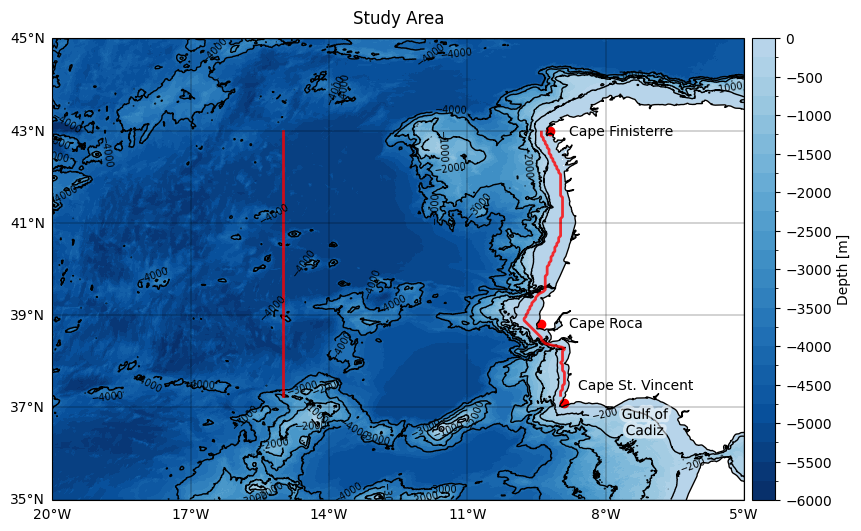

In [16]:
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-20.01, -4.99, 45.01, 34.99])
ax.coastlines()
ax.add_feature(cfeature.LAND, color = 'white', zorder = 0)
gls = ax.gridlines(draw_labels=True, linewidth = 0.25, color = 'black')
gls.top_labels = False 
gls.right_labels = False  
gls.xlocator = mticker.FixedLocator(np.arange(-20, -4, 3))
gls.ylocator = mticker.FixedLocator(np.arange(35, 46, 2))

#new_cmap = cmr.get_sub_cmap(cmo.deep_r, 0, 0.8)
# adjust cmap
new_cmap = cmr.get_sub_cmap('Blues_r', 0, 0.7)
cp = bathymetry.elevation.plot(add_colorbar = False, cmap = new_cmap, levels = np.arange(0, - 6250, -250), extend = 'neither', zorder = -10)#= [0, -50, -100, -150, -200, -250, -300, -350, -400, -450, -500, -600, -700, -800, -900, -1000, -1500, -2000, -3000, -4000, -5000, -6000])
plt.colorbar(cp, ticks = np.arange(0, -6500, -500), label = 'Depth [m]', fraction = 0.0319, pad = 0.01)

# add some contours
clp = bathymetry.elevation.plot.contour(add_colorbar = False, colors = 'black', linewidths = 1, linestyles = '-', levels = [-200, -1000, -2000, -3000, -4000]) 
plt.clabel(clp, fontsize = 7)

# mark relevant points
# add mid-shelf between 37.25 and 43
lats = np.where((mid_shelf_lat >= 37.25) & (mid_shelf_lat <= 43), mid_shelf_lat, np.nan)
lons = np.where((mid_shelf_lat >= 37.25) & (mid_shelf_lat <= 43), mid_shelf_lon, np.nan)
plt.plot(lons, lats, color = 'red', lw = 2, alpha = 0.8);
# add line at 15°W
plt.plot([-15, -15], [37.25, 43], color = 'red', lw = 2, alpha = 0.8)

plt.scatter([-9.2, -9.4, -8.9], [43, 38.8, 37.1], marker = 'o', color = 'red')
plt.text(-8.8, 42.9, 'Cape Finisterre')
plt.text(-8.8, 38.75, 'Cape Roca')
plt.text(-8.6, 37.4, 'Cape St. Vincent')
txt = plt.text(-7.15, 36.4, 'Gulf of\nCadiz', horizontalalignment='center');
txt.set_path_effects([path_effects.withStroke(linewidth=5, foreground='w', alpha = 0.5)]) # white underlay text

plt.title('Study Area')
plt.savefig('Study_area.png', dpi = 300, bbox_inches = 'tight')

## Upwelling season mean (usm)

In [17]:
Ek_usm = Ek_summer_mean[['ek_trans_u', 'ek_trans_v']].mean(dim = 'time') * 1000 # make it m3/s km
Ek_usm['magnitude'] = np.hypot(Ek_usm.ek_trans_u, Ek_usm.ek_trans_v)
SST_usm = SST_summer_mean.SST.mean(dim = 'time')
SLP_usm = SLP_summer_mean.msl.where(SLP_summer_mean.lsm).mean(dim = 'time') * 0.01 # make it hPa
SSH_usm = SSH_summer_mean.mean(dim = 'time') * 100 # make it cm

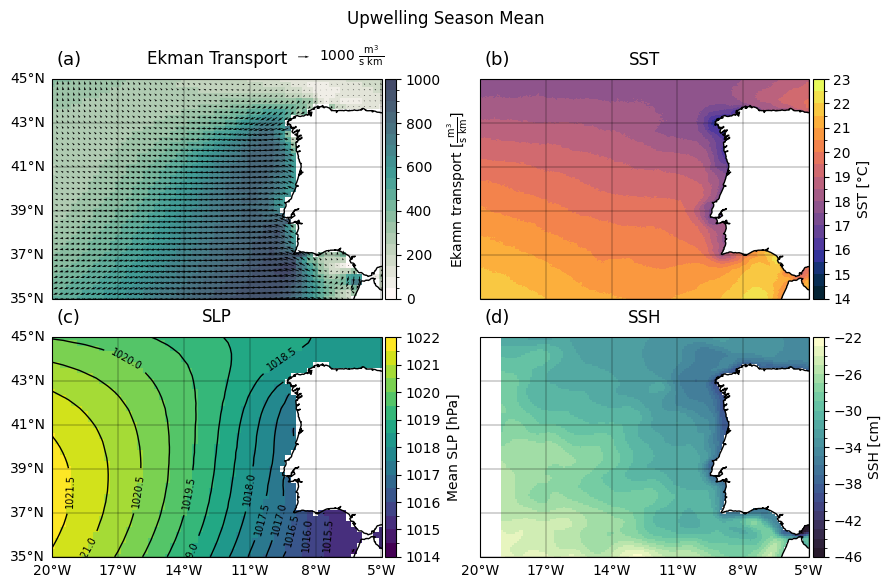

In [18]:
fig, ax = plt.subplots(2, 2, figsize = (9,6), subplot_kw={'projection': ccrs.PlateCarree()})
ax = ax.flatten()

# set up cartopy for all plots
for i in np.arange(4):
    ax[i].set_extent([-20.01, -4.99, 45.01, 34.99])
    ax[i].coastlines()
    gls = ax[i].gridlines(draw_labels=True, linewidth = 0.25, color = 'black')
    gls.top_labels = False 
    gls.right_labels = False
    gls.xlocator = mticker.FixedLocator(np.arange(-20, -4, 3))
    gls.ylocator = mticker.FixedLocator(np.arange(35, 46, 2))
    if i in (1, 3):
        gls.left_labels = False
    if i in (0, 1):
        gls.bottom_labels = False

# col = np.hypot(Ek_usm.ek_trans_u, Ek_usm.ek_trans_v)
# im = ax[0].quiver(Ek_usm.lon, Ek_usm.lat, Ek_usm.ek_trans_u, Ek_usm.ek_trans_v, col, angles='xy', scale_units='xy', scale = 2*1000, clim = [0,1*1000]) 
# mag = np.hypot(Ek_usm.ek_trans_u, Ek_usm.ek_trans_v)

cp = Ek_usm.magnitude.plot(ax = ax[0], add_colorbar = False, cmap = cmo.tempo, vmin = 0, vmax = 1000, alpha = 0.8, levels = np.arange(0, 1050, 50))
im = ax[0].quiver(Ek_usm.lon, Ek_usm.lat, Ek_usm.ek_trans_u, Ek_usm.ek_trans_v, angles='xy', scale_units='xy', scale = 2*1000, clim = [0,1*1000]) 
plt.colorbar(cp, ax = ax[0], label = r'Ekamn transport [$\frac{\rm m^3}{\rm s \ km}$]', fraction = 0.0319, pad = 0.01, ticks = np.arange(0, 1200, 200));
ax[0].set_title('Ekman Transport')
ax[0].text(-19.8, 45.65, '(a)', fontsize = 13)
ax[0].quiverkey(im, 0.78, 1.1, 1*1000, r'1000 $\frac{\rm m^3}{\rm s \ km}$', labelpos='E')

cp = SST_usm.plot(ax = ax[1], add_colorbar = False, cmap = cmo.thermal, vmin = 14, vmax = 23, levels = np.arange(14, 23.5, 0.5))
plt.colorbar(cp, ax = ax[1], label = 'SST [°C]', fraction = 0.0319, pad = 0.01) 
ax[1].set_title('SST', pad = 10)
ax[1].text(-19.8, 45.65, '(b)', fontsize = 13)

cp = SLP_usm.plot(ax = ax[2], add_colorbar = False, cmap = 'viridis', vmin = 1014, vmax = 1022, levels = np.arange(1014, 1022.5, 0.5))
clp = SLP_usm.plot.contour(ax = ax[2], colors = 'black', linewidths = 1, levels = np.arange(1014, 1022.5, 0.5))
plt.colorbar(cp, ax = ax[2], label = 'Mean SLP [hPa]', fraction = 0.0319, pad = 0.01) 
plt.clabel(clp, fontsize = 7)
ax[2].set_title('SLP')
ax[2].text(-19.8, 45.65, '(c)', fontsize = 13)

cp = SSH_usm.plot(ax = ax[3], add_colorbar = False, cmap = cmo.deep_r, vmin = -46, vmax = -22, levels = np.arange(-46, -21, 1))
cbar = plt.colorbar(cp, ax = ax[3], label = 'SSH [cm]', fraction = 0.0319, pad = 0.01, ticks = np.arange(-46, -20, 4))
#cbar.ax.locator_params(nbins = 4)
ax[3].set_title('SSH', pad = 10)
ax[3].text(-19.8, 45.65, '(d)', fontsize = 13)

fig.suptitle('Upwelling Season Mean')
fig.tight_layout(pad=1, w_pad=0, h_pad=-0.8)
fig.savefig('Upwelling_Season_Mean.png', dpi = 300, bbox_inches = 'tight')

In [19]:
# min and max values overall 
print('Ek (combined) min:', Ek_usm.magnitude.min().values, 'max: ', Ek_usm.magnitude.max().values)
print('SST min: ', SST_usm.min().values, 'max: ', SST_usm.max().values)
print('SLP min: ', SLP_usm.min().values, 'max: ', SLP_usm.max().values)
print('SSH min: ', SSH_usm.min().values, 'max: ', SSH_usm.max().values)

Ek (combined) min: 31.602329580437676 max:  966.3344945487348
SST min:  14.744092140921408 max:  22.40334688346884
SLP min:  1014.9831 max:  1021.72076
SSH min:  -45.65161683719141 max:  -22.636673215304643


## Upwelling season trend

In [20]:
Ek_u_us_trend, Ek_u_us_pvalues = calc_trend_and_significance(Ek_summer_mean.ek_trans_u * 1000) # make it m3/s km
Ek_v_us_trend, Ek_v_us_pvalues = calc_trend_and_significance(Ek_summer_mean.ek_trans_v * 1000) # make it m3/s km
Ek_summer_mean['magnitude'] = np.hypot(Ek_summer_mean.ek_trans_u * 1000, Ek_summer_mean.ek_trans_v * 1000) # make it m3/s km   
Ek_mag_us_trend, Ek_mag_us_pvalues = calc_trend_and_significance(Ek_summer_mean.magnitude) # trend of the Ekman transport magnitude 
SST_us_trend, SST_us_pvalues = calc_trend_and_significance(SST_summer_mean.SST)
SLP_us_trend, SLP_us_pvalues = calc_trend_and_significance(SLP_summer_mean.msl.where(SLP_summer_mean.lsm))
SSH_us_trend, SSH_us_pvalues = calc_trend_and_significance(SSH_summer_mean * 1000) # make it mm

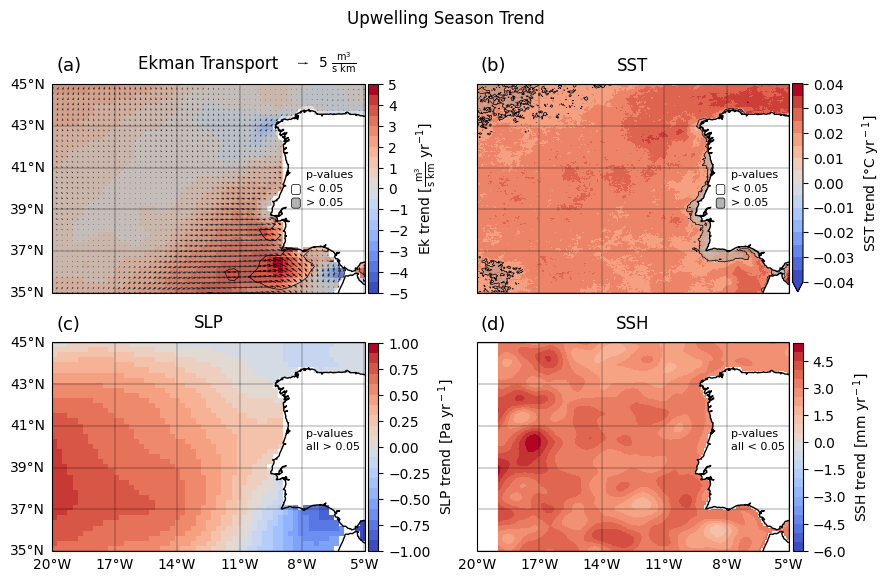

In [21]:
sig_level = 0.05 # set significance level for plotting p-values
cmap = plt.get_cmap('coolwarm')

fig, ax = plt.subplots(2, 2, figsize = (9,6), subplot_kw={'projection': ccrs.PlateCarree()})
ax = ax.flatten()

# set up cartopy for all plots
for i in np.arange(4):
    ax[i].set_extent([-20.01, -4.99, 45.01, 34.99])
    ax[i].coastlines()
    gls = ax[i].gridlines(draw_labels=True, linewidth = 0.25, color = 'black')
    gls.top_labels = False 
    gls.right_labels = False
    gls.xlocator = mticker.FixedLocator(np.arange(-20, -4, 3))
    gls.ylocator = mticker.FixedLocator(np.arange(35, 46, 2))
    if i in (1, 3):
        gls.left_labels = False
    if i in (0, 1):
        gls.bottom_labels = False


## Ek
mag = np.hypot(Ek_u_us_trend, Ek_v_us_trend)
norm = mcolors.BoundaryNorm(np.arange(-5, 5.5, 0.5), ncolors = cmap.N, clip = True)
cp = ax[0].imshow(Ek_mag_us_trend, origin = 'lower', cmap = cmap, extent=[-20, -5, 35, 45], norm = norm) 
cb = plt.colorbar(cp, ax = ax[0], label = r'Ek trend [$\frac{\rm m^3}{\rm s \ km}$ yr$^{-1}$]', fraction = 0.0319, pad = 0.01, ticks = np.arange(-5, 6, 1))
cb.ax.minorticks_off()
im = ax[0].quiver(Ek_usm.lon, Ek_usm.lat, Ek_u_us_trend, Ek_v_us_trend, angles='xy', scale_units='xy', scale = 10) #, clim = [0,1*1000]) 
## alternative code for plotting coloured arrows (instead of black arrows ontop of imshow plot)
#im = ax[0].quiver(Ek_usm.lon, Ek_usm.lat, Ek_u_us_trend, Ek_v_us_trend, mag, cmap = 'coolwarm', angles='xy', scale_units='xy', scale = 10, clim = [-5, 5]) 
#plt.colorbar(im, ax = ax[0], label = r'Ekamn transport [$\frac{\rm m^3}{\rm s \ km}$]', fraction = 0.0319, pad = 0.01)
ax[0].quiverkey(im, 0.82, 1.1, 5, r'5 $\frac{\rm m^3}{\rm s \ km}$', labelpos = 'E')
ax[0].set_title('Ekman Transport')
ax[0].text(-19.8, 45.65, '(a)', fontsize = 13)

ax[0].contour(Ek_usm.lon, Ek_usm.lat, Ek_mag_us_pvalues, [0.05], cmap = 'magma', linewidths = 0.5)
ax[0].contourf(Ek_usm.lon, Ek_usm.lat, Ek_mag_us_pvalues, [0.05, 1], cmap = 'binary', alpha = 0.3)

# legend
ax[0].text(-7.8, 40.5, s = 'p-values', fontsize = 8)
ax[0].text(-8.4, 39.85, s='  ', size = 5, bbox=dict(boxstyle="round", ec=(0, 0, 0), fc=(1, 1, 1), linewidth = 0.5))
ax[0].text(-7.8, 39.85, '< 0.05', fontsize = 8)
ax[0].text(-8.4, 39.2, s='  ', size = 5, bbox=dict(boxstyle="round", ec=(0, 0, 0), fc=(0.7, 0.7, 0.7), linewidth = 0.5))
ax[0].text(-7.8, 39.2, '> 0.05', fontsize = 8)

## SST
norm = mcolors.BoundaryNorm(np.arange(-0.04, 0.045, 0.005), ncolors = cmap.N, clip = True)
cp = ax[1].imshow(SST_us_trend, origin = 'lower', cmap = cmap, extent=[-20, -5, 35, 45], norm = norm)
cb = plt.colorbar(cp, ax = ax[1], label = r'SST trend [°C yr$^{\rm -1}$]', fraction = 0.0319, pad = 0.01, extend = 'min') 
cb.ax.minorticks_off()
ax[1].set_title('SST', pad = 10)

#sig_indices = np.where(SST_us_pvalues < sig_level)
#plt.scatter(SST_usm.lon[sig_indices[1]], SST_usm.lat[sig_indices[0]], color = 'k')
ax[1].contour(SST_usm.lon, SST_usm.lat, SST_us_pvalues, [0.05], cmap = 'magma', linewidths = 0.5)
ax[1].contourf(SST_usm.lon, SST_usm.lat, SST_us_pvalues, [0.05, 1], cmap = 'binary', alpha = 0.3)

# legend
ax[1].text(-19.8, 45.65, '(b)', fontsize = 13)
ax[1].text(-7.8, 40.5, s = 'p-values', fontsize = 8)
ax[1].text(-8.4, 39.85, s='  ', size = 5, bbox=dict(boxstyle="round", ec=(0, 0, 0), fc=(1, 1, 1), linewidth = 0.5))
ax[1].text(-7.8, 39.85, '< 0.05', fontsize = 8)
ax[1].text(-8.4, 39.2, s='  ', size = 5, bbox=dict(boxstyle="round", ec=(0, 0, 0), fc=(0.7, 0.7, 0.7), linewidth = 0.5))
ax[1].text(-7.8, 39.2, '> 0.05', fontsize = 8)

## SLP 
norm = mcolors.BoundaryNorm(np.arange(-1, 1.1, 0.1), ncolors = cmap.N, clip = True)
cp = ax[2].imshow(SLP_us_trend, origin = 'lower', cmap = cmap, extent=[-20, -5, 35, 45], norm = norm) 
cb = plt.colorbar(cp, ax = ax[2], label = r'SLP trend [Pa yr$^{\rm -1}$]', fraction = 0.0319, pad = 0.01, ticks = np.arange(-1, 1.25, 0.25))
cb.ax.minorticks_off()
ax[2].set_title('SLP')
ax[2].text(-19.8, 45.65, '(c)', fontsize = 13)
ax[2].text(-7.8, 40.5, s = 'p-values', fontsize = 8)
ax[2].text(-7.8, 39.85, 'all > 0.05', fontsize = 8)

#ax[2].contour(SLP_usm.lon, SLP_usm.lat, SLP_us_pvalues, [0.05], cmap = 'magma', linewidths = 0.5)
#ax[2].contourf(SLP_usm.lon, SLP_usm.lat, SLP_us_pvalues, [0.05, 1], cmap = 'binary', alpha = 0.1)

norm = mcolors.BoundaryNorm(np.arange(-6, 6, 0.5), ncolors = cmap.N, clip = True)
cp = ax[3].imshow(SSH_us_trend, origin = 'lower', cmap = cmap, extent=[-19, -5, 35, 45], norm = norm) 
cb = plt.colorbar(cp, ax = ax[3], label = r'SSH trend [mm yr$^{\rm -1}$]', fraction = 0.0319, pad = 0.01) #, ticks = np.arange(-1, 1.2, 0.2))
cb.ax.minorticks_off()
ax[3].set_title('SSH', pad = 10)
ax[3].text(-19.8, 45.65, '(d)', fontsize = 13)
ax[3].text(-7.8, 40.5, s = 'p-values', fontsize = 8)
ax[3].text(-7.8, 39.85, 'all < 0.05', fontsize = 8)

#ax[3].contour(SSH_usm.lon, SSH_usm.lat, SSH_us_pvalues, [0.05], cmap = 'magma', linewidths = 0.5)
#ax[3].contourf(SSH_usm.lon, SSH_usm.lat, SSH_us_pvalues, [0.05, 1], cmap = 'binary', alpha = 0.1)

fig.suptitle('Upwelling Season Trend')
fig.tight_layout(pad=1, w_pad=0, h_pad=-0.8)
fig.savefig('Upwelling_Season_Trend.png', dpi = 300, bbox_inches = 'tight')


## improve vis

In [22]:
print('Ek mag trend min: ', np.nanmin(Ek_mag_us_trend), 'max: ', np.nanmax(Ek_mag_us_trend))
print('SST trend min: ', np.nanmin(SST_us_trend), 'max: ', np.nanmax(SST_us_trend))
print('SLP trend min: ', np.nanmin(SLP_us_trend), 'max: ', np.nanmax(SLP_us_trend))
print('SSH trend min: ', np.nanmin(SSH_us_trend), 'max: ', np.nanmax(SSH_us_trend))

Ek mag trend min:  -3.512756948946216 max:  4.786907528345153
SST trend min:  -0.12730381339527674 max:  0.03988124274099877
SLP trend min:  -1.065193543118467 max:  0.8545228114111498
SSH trend min:  1.1692196974146927 max:  5.407909397529664


In [23]:
# overall SST trend in study region
x = np.arange(len(SST_summer_mean.time))
linregress(x, SST_summer_mean.SST.mean(dim = ['lon', 'lat']))

LinregressResult(slope=0.02168818822039623, intercept=19.045041944104543, rvalue=0.534019890300077, pvalue=0.00032318111523887006, stderr=0.00549835430822864, intercept_stderr=0.12777020800390396)

In [24]:
# overall SSH trend in study region
x = np.arange(len(SSH_summer_mean.time))
linregress(x, SSH_summer_mean.mean(dim = ['lon', 'lat']))

LinregressResult(slope=0.0031858328704947475, intercept=-0.34561506028217154, rvalue=0.910760597784234, pvalue=7.0567303370204705e-12, stderr=0.0002779830643389891, intercept_stderr=0.0045337665753512665)

## UIs

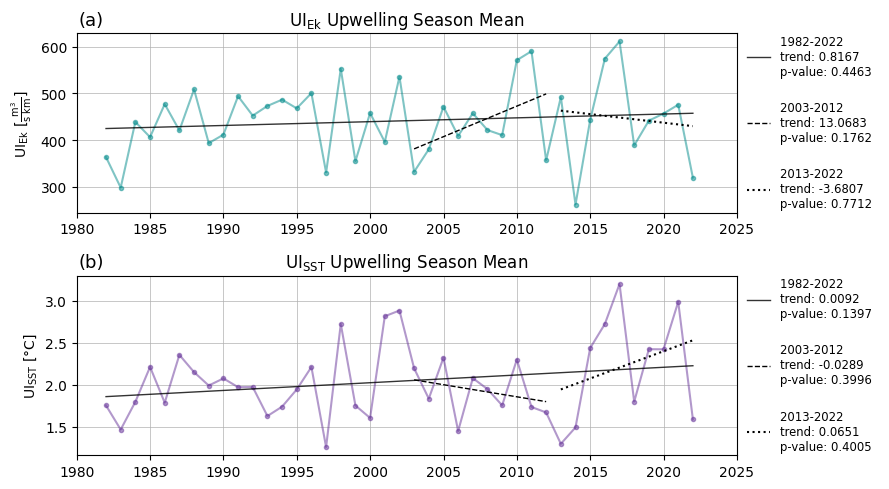

In [31]:
fig = plt.figure(figsize = (9, 5))
ax1 = plt.subplot(2,1,1)
plot_trend(Ek_summer_mean.time, Ek_summer_mean.UI_mean * 1000, title = r'$\rm UI_{Ek}$ Upwelling Season Mean', 
           ylabel = r'$\rm UI_{Ek} \ [\frac{\rm m^3}{\rm s \ km}]$', last_decades = True)
ax1.text(3700, 645, '(a)', fontsize = 13) 
ax2 = plt.subplot(2,1,2)
plot_trend(SST_summer_mean.time, SST_summer_mean.UI_mean, col = 'rebeccapurple', title = r'$\rm UI_{SST}$ Upwelling Season Mean', 
           ylabel = r'$\rm UI_{SST}$ [°C]', last_decades = True)
ax2.text(3700, 3.4, '(b)', fontsize = 13);
fig.savefig('UIs.png', dpi = 300, bbox_inches = 'tight')

## UIs long

In [32]:
# UI Ek and ERA5 SST over the whole period
MTSS_all = xr.open_dataset('/Users/marie-louisekorte/Documents/Uni Leipzig/Lisbon/Data.nosync/MTSS_all_weekly.nc')
ERA5_SST = xr.open_dataset('/Users/marie-louisekorte/Documents/Uni Leipzig/Lisbon/Data.nosync/ERA5_SST_weekly.nc')

In [33]:
## select same 'end point' -> optional, I decided to go with longest possible period
#MTSS_all = MTSS_all.sel(time = slice(None, '31/12/2022'))
#ERA5_SST = ERA5_SST.sel(time = slice(None, '31/12/2022'))

In [34]:
Ek_all = MTSS_all
Angles 
Ek_all = my_functions.calc_upwelling_index(MTSS_all, MTSS_all.lat, MTSS_all.lon, MTSS_all.metss.where(MTSS_all.lsm), MTSS_all.mntss.where(MTSS_all.lsm), near_shore = True, angles = Angles.angle_phi)
Ek_all = Ek_all.drop_vars('UI')
Ek_all['UI'] = Ek_all.UI_ns 

# UI SST and SSH
ERA5_SST = my_functions.add_mid_shelf(ERA5_SST, mid_shelf_lat, mid_shelf_lon)
ERA5_SST['UI'] = ERA5_SST.SST.where(ERA5_SST.lon == -15) - ERA5_SST.SST.where(ERA5_SST.mid_shelf).mean(dim = 'lon')
ERA5_SST.UI.attrs.update({'Name' : 'SST upwelling index', 'Info' : 'SST at 15° - SST at mid-shelf', 'Sign' : 'positive inidcates upwelling'})

In [35]:
# choose min 37.25 and max 43°N -> this is where the UI annual mean of the upwelling season mean is positive (except at Setubal 38.25)
Ek_all['UI_mean'] = Ek_all.UI.where((Ek_all.lat >= 37.25)&(Ek_all.lon <= 43)).mean(dim = ['lat', 'lon'])
ERA5_SST = my_functions.calc_meridional_mean(ERA5_SST, lon = -15, min_lat = 37.25, max_lat = 43.5)

In [36]:
Ek_all_summer = my_functions.subset_summer(Ek_all)
ERA5_SST_summer = my_functions.subset_summer(ERA5_SST)

In [37]:
Ek_all_summer_mean = Ek_all_summer['UI_mean'].resample(time = 'YE', label = 'left').mean(dim = 'time') # label is assigned to start of year
ERA5_SST_summer_mean = ERA5_SST_summer['UI_mean'].resample(time = 'YE', label = 'left').mean(dim = 'time') # label is assigned to start of year

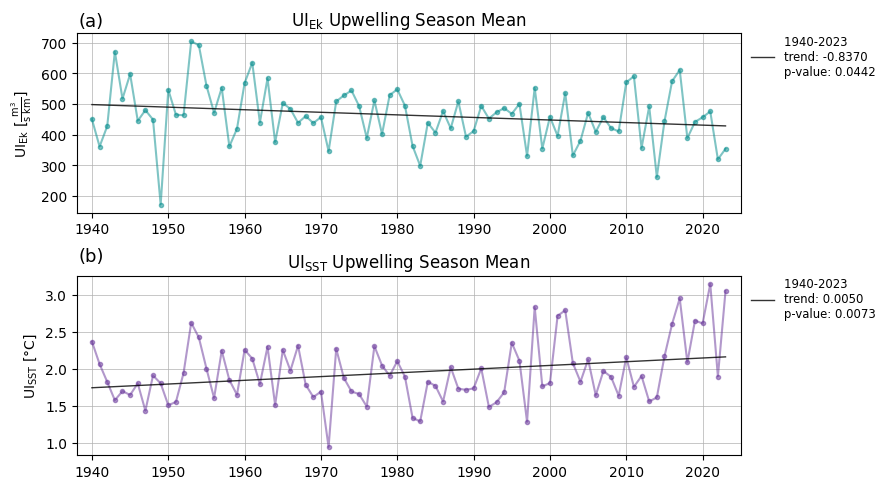

In [38]:
fig = plt.figure(figsize = (9, 5))
ax1 = plt.subplot(2,1,1)
plot_trend(Ek_all_summer_mean.time, Ek_all_summer_mean * 1000, title = r'$\rm UI_{Ek}$ Upwelling Season Mean', 
           ylabel = r'$\rm UI_{Ek} \ [\frac{\rm m^3}{\rm s \ km}]$', long = True, last_decades = False)
ax1.text(-11600, 755, '(a)', fontsize = 13) 
ax2 = plt.subplot(2,1,2)
plot_trend(ERA5_SST_summer_mean.time, ERA5_SST_summer_mean, col = 'rebeccapurple', title = r'$\rm UI_{SST}$ Upwelling Season Mean', 
           ylabel = r'$\rm UI_{SST}$ [°C]', long = True, last_decades = False)
ax2.text(-11600, 3.45, '(b)', fontsize = 13);
fig.savefig('UIs_long.png', dpi = 300, bbox_inches = 'tight')

## Correlation UI<sub>SST</sub> and UI<sub>Ek</sub>

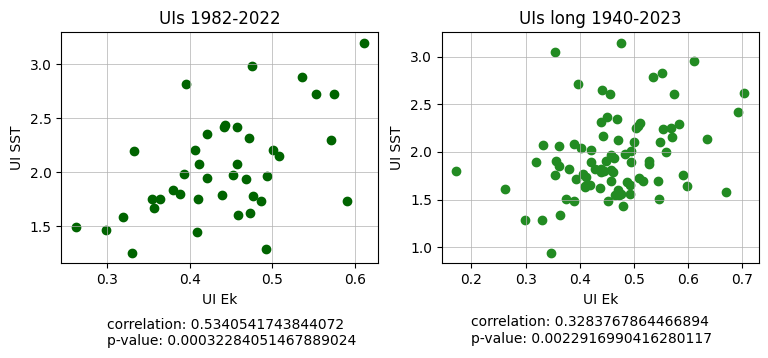

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (9, 3))
ax1.scatter(Ek_summer_mean.UI_mean, SST_summer_mean.UI_mean, color = 'darkgreen')
ax1.set_title('UIs 1982-2022')
ax1.set_xlabel('UI Ek')
ax1.set_ylabel('UI SST')
ax1.grid(lw = 0.5)

result = pearsonr(Ek_summer_mean.UI_mean, SST_summer_mean.UI_mean)
ax1.text(0.3, 0.4, f'correlation: {result[0]} \np-value: {result[1]}')

ax2.scatter(Ek_all_summer_mean, ERA5_SST_summer_mean, color = 'forestgreen')
ax2.set_title('UIs long 1940-2023')
ax2.set_xlabel('UI Ek')
ax2.set_ylabel('UI SST')
ax2.grid(lw = 0.5)

result = pearsonr(Ek_all_summer_mean, ERA5_SST_summer_mean)
ax2.text(0.2, 0, f'correlation: {result[0]} \np-value: {result[1]}');

## Correlation NAO

In [40]:
NAO = xr.open_dataset('/Users/marie-louisekorte/Documents/Uni Leipzig/Lisbon/Data.nosync/NAO_weekly.nc')
NAO = NAO.sel(time = slice('01/01/1982', '31/12/2022'))
NAO_summer = my_functions.subset_summer(NAO)
NAO_summer_mean = NAO_summer.resample(time = 'YE', label = 'left').mean(dim = 'time')

In [42]:
NAO_1_adv = my_functions.subset_summer(NAO, min_week=21, max_week=38).NAO
NAO_2_adv = my_functions.subset_summer(NAO, min_week=20, max_week=37).NAO
NAO_3_adv = my_functions.subset_summer(NAO, min_week=19, max_week=36).NAO
NAO_4_adv = my_functions.subset_summer(NAO, min_week=18, max_week=35).NAO
NAO_5_adv = my_functions.subset_summer(NAO, min_week=17, max_week=34).NAO
NAO_6_adv = my_functions.subset_summer(NAO, min_week=16, max_week=33).NAO

In [43]:
NAO_7_adv = my_functions.subset_summer(NAO, min_week=15, max_week=32).NAO
NAO_8_adv = my_functions.subset_summer(NAO, min_week=14, max_week=31).NAO
NAO_9_adv = my_functions.subset_summer(NAO, min_week=13, max_week=30).NAO
NAO_10_adv = my_functions.subset_summer(NAO, min_week=12, max_week=29).NAO
NAO_11_adv = my_functions.subset_summer(NAO, min_week=11, max_week=28).NAO
NAO_12_adv = my_functions.subset_summer(NAO, min_week=10, max_week=27).NAO

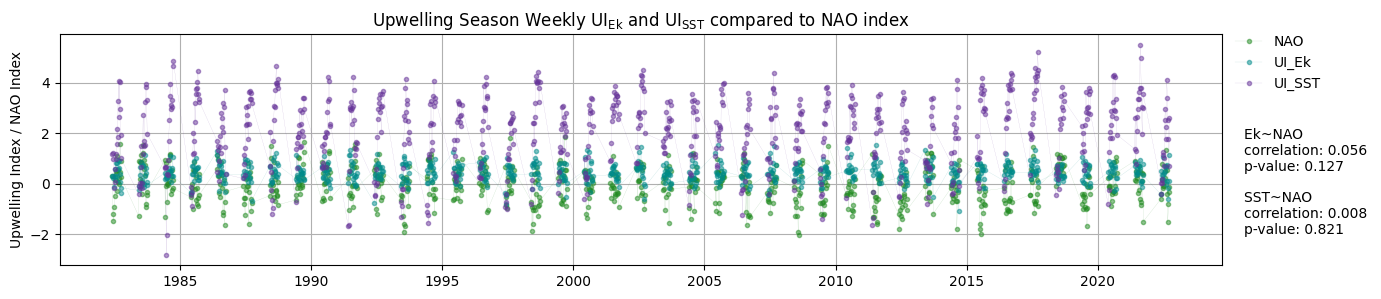

In [44]:
plt.figure(figsize = (15, 3))
NAO_summer.NAO.plot(label = 'NAO', color = 'forestgreen', marker = '.', alpha = 0.5, lw = 0.1)
Ek_summer.UI_mean.plot(label = 'UI_Ek', color = 'darkcyan', marker = '.', alpha = 0.5, lw = 0.1)
SST_summer.UI_mean.plot(label = 'UI_SST', color = 'rebeccapurple', marker = '.', alpha = 0.5, lw = 0.1)
plt.grid()
plt.legend(edgecolor = 'none', bbox_to_anchor=(1, 1.05))
plt.title(r'Upwelling Season Weekly $\rm UI_{Ek}$ and $\rm UI_{SST}$ compared to NAO index')
plt.ylabel('Upwelling Index / NAO Index')
plt.xlabel('')
#plt.xlim(dates.date2num(['1985-01-01']), dates.date2num(['1985-12-31']))
result = pearsonr(Ek_summer.UI_mean, NAO_summer.NAO)
plt.text(20300, 0.5, f'Ek~NAO \ncorrelation: {result[0]:.3f} \np-value: {result[1]:.3f}');
result = pearsonr(SST_summer.UI_mean, NAO_summer.NAO)
plt.text(20300, -2, f'SST~NAO \ncorrelation: {result[0]:.3f} \np-value: {result[1]:.3f}');

In [45]:
# With NAO 1, 2, 3, 4, 5, 6 weeks advanced
var = [NAO_1_adv, NAO_2_adv, NAO_3_adv, NAO_4_adv, NAO_5_adv, NAO_6_adv, NAO_7_adv, NAO_8_adv, NAO_9_adv, NAO_10_adv, NAO_11_adv, NAO_12_adv]
for i in np.arange(0,12):
    print(f'{i+1} Week advanced')
    result = pearsonr(Ek_summer.UI_mean, var[i])
    print(f'Ek~NAO \ncorrelation: {result[0]:.3f} p-value: {result[1]:.5f}');
    result = pearsonr(SST_summer.UI_mean, var[i])
    print(f'SST~NAO \ncorrelation: {result[0]:.3f} p-value: {result[1]:.5f}');
    print(' ')

1 Week advanced
Ek~NAO 
correlation: -0.104 p-value: 0.00459
SST~NAO 
correlation: -0.029 p-value: 0.43672
 
2 Week advanced
Ek~NAO 
correlation: -0.135 p-value: 0.00023
SST~NAO 
correlation: -0.057 p-value: 0.12086
 
3 Week advanced
Ek~NAO 
correlation: -0.063 p-value: 0.08813
SST~NAO 
correlation: -0.069 p-value: 0.05961
 
4 Week advanced
Ek~NAO 
correlation: -0.085 p-value: 0.02039
SST~NAO 
correlation: -0.095 p-value: 0.01020
 
5 Week advanced
Ek~NAO 
correlation: -0.055 p-value: 0.13803
SST~NAO 
correlation: -0.081 p-value: 0.02747
 
6 Week advanced
Ek~NAO 
correlation: -0.046 p-value: 0.21315
SST~NAO 
correlation: -0.129 p-value: 0.00043
 
7 Week advanced
Ek~NAO 
correlation: 0.041 p-value: 0.26156
SST~NAO 
correlation: -0.132 p-value: 0.00031
 
8 Week advanced
Ek~NAO 
correlation: 0.028 p-value: 0.45511
SST~NAO 
correlation: -0.111 p-value: 0.00258
 
9 Week advanced
Ek~NAO 
correlation: -0.006 p-value: 0.86164
SST~NAO 
correlation: -0.129 p-value: 0.00045
 
10 Week advanced
Ek~N

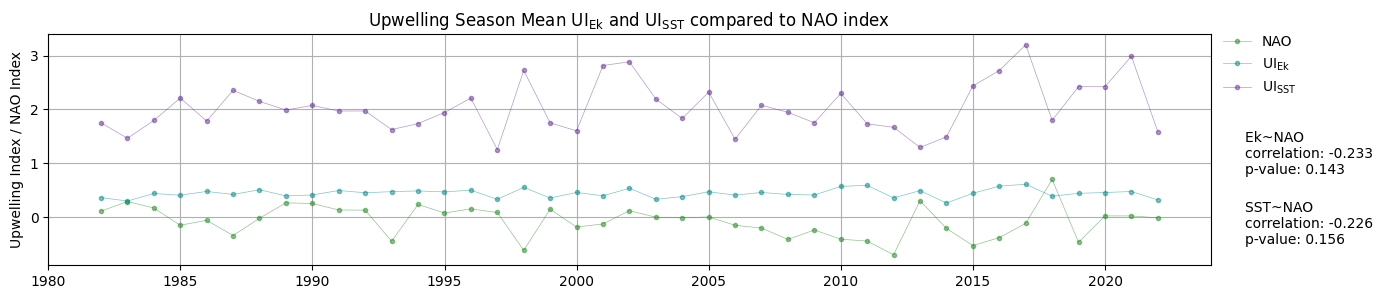

In [46]:
plt.figure(figsize = (15, 3))
NAO_summer_mean.NAO.plot(label = 'NAO', color = 'forestgreen', marker = '.', alpha = 0.5, lw = 0.5)
Ek_summer_mean.UI_mean.plot(label = r'$\rm UI_{Ek}$', color = 'darkcyan', marker = '.', alpha = 0.5, lw = 0.5)
SST_summer_mean.UI_mean.plot(label = r'$\rm UI_{SST}$', color = 'rebeccapurple', marker = '.', alpha = 0.5, lw = 0.5)
plt.grid()
plt.legend(edgecolor = 'none', bbox_to_anchor=(1, 1.05))
plt.title(r'Upwelling Season Mean $\rm UI_{Ek}$ and $\rm UI_{SST}$ compared to NAO index')
plt.ylabel('Upwelling Index / NAO Index')
plt.xlabel('')
#plt.xlim(dates.date2num(['1985-01-01']), dates.date2num(['1985-12-31']))
result = pearsonr(Ek_summer_mean.UI_mean, NAO_summer_mean.NAO)
plt.text(20200, 0.8, f'Ek~NAO \ncorrelation: {result[0]:.3f} \np-value: {result[1]:.3f}');
result = pearsonr(SST_summer_mean.UI_mean, NAO_summer_mean.NAO)
plt.text(20200, -0.5, f'SST~NAO \ncorrelation: {result[0]:.3f} \np-value: {result[1]:.3f}');

## Extremes

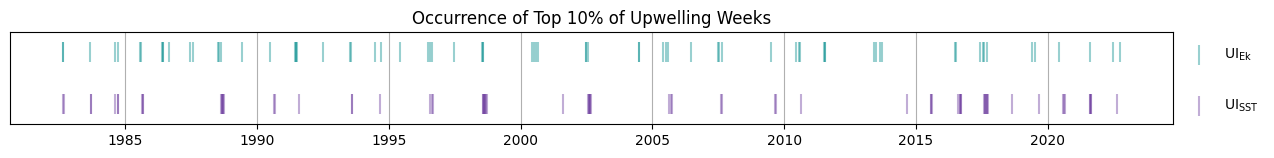

In [47]:
Ek_sub_summer, SST_sub_summer = plot_extreme_occurrence(Ek_summer, SST_summer, title = 'Occurrence of Top 10% of Upwelling Weeks', 
                                variables = True, save = True, save_fig_as = 'Extreme_top_10') # by default does to 10% 

In [180]:
# find number and dates of weeks where both indices are extreme
extreme_weeks = [Ek_sub_summer, SST_sub_summer]
u, c = np.unique(extreme_weeks, return_counts = True)
dup = u[c > 1]
print('Number of weeks where extremes coincide:', len(dup), '\nTotal number of extremes per UI:', len(Ek_sub_summer))
dup

Number of weeks where extremes coincide: 12 
Total number of extremes per UI: 74


array(['1982-08-24T00:00:00.000000000', '1984-09-18T00:00:00.000000000',
       '1988-08-23T00:00:00.000000000', '1996-07-30T00:00:00.000000000',
       '1996-08-27T00:00:00.000000000', '1998-07-28T00:00:00.000000000',
       '1998-08-04T00:00:00.000000000', '2002-07-30T00:00:00.000000000',
       '2007-08-21T00:00:00.000000000', '2017-08-08T00:00:00.000000000',
       '2017-09-12T00:00:00.000000000', '2021-08-17T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [182]:
# find number and dates of weeks Ek extreme preceeded SST extreme both indices are extreme
extreme_weeks = [Ek_sub_summer + np.timedelta64(7, 'D'), SST_sub_summer]
u, c = np.unique(extreme_weeks, return_counts = True)
dup_preceed = u[c > 1]
print('Number of weeks where extremes coincide:', len(dup_preceed), '\nTotal number of extremes per UI:', len(Ek_sub_summer))
dup_preceed

Number of weeks where extremes coincide: 11 
Total number of extremes per UI: 74


array(['1982-08-24T00:00:00.000000000', '1984-08-14T00:00:00.000000000',
       '1984-09-25T00:00:00.000000000', '1988-08-30T00:00:00.000000000',
       '1996-09-03T00:00:00.000000000', '1998-08-04T00:00:00.000000000',
       '1998-08-11T00:00:00.000000000', '2002-08-06T00:00:00.000000000',
       '2017-08-15T00:00:00.000000000', '2017-09-19T00:00:00.000000000',
       '2021-08-24T00:00:00.000000000'], dtype='datetime64[ns]')

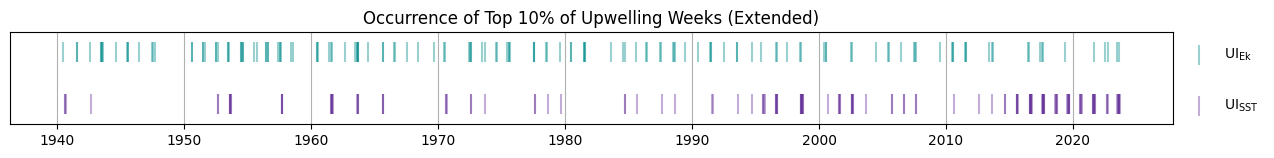

In [49]:
Ek_all_sub_summer, SST_all_sub_summer = plot_extreme_occurrence(Ek_all_summer, ERA5_SST_summer, title = 'Occurrence of Top 10% of Upwelling Weeks (Extended)', 
                                variables = True, save = True, save_fig_as = 'Extreme_top_10_extended') # by default does to 10% 

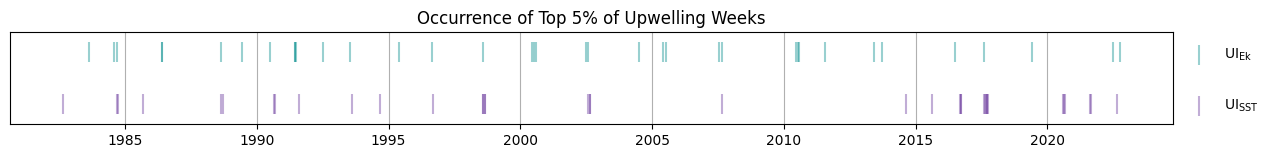

In [50]:
Ek_sub_summer_5, SST_sub_summer_5 = plot_extreme_occurrence(Ek_summer, SST_summer, title = 'Occurrence of Top 5% of Upwelling Weeks', 
                                sub_start = 0, sub_stop = 0.05, variables = True, save = True, save_fig_as = 'Extreme_top_10') 

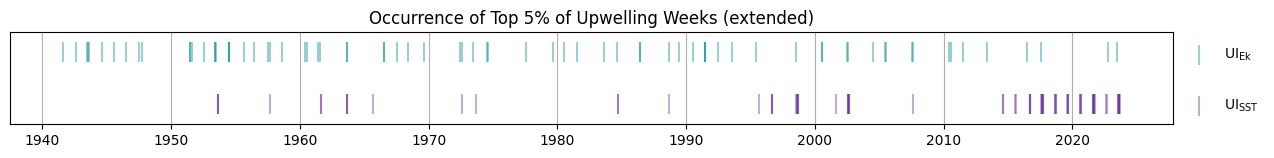

In [51]:
Ek_all_sub_summer_5, SST_all_sub_summer_5 = plot_extreme_occurrence(Ek_all_summer, ERA5_SST_summer, title = 'Occurrence of Top 5% of Upwelling Weeks (extended)', 
                                sub_start = 0, sub_stop = 0.05, variables = True, save = False, save_fig_as = 'Extreme_top_10') 

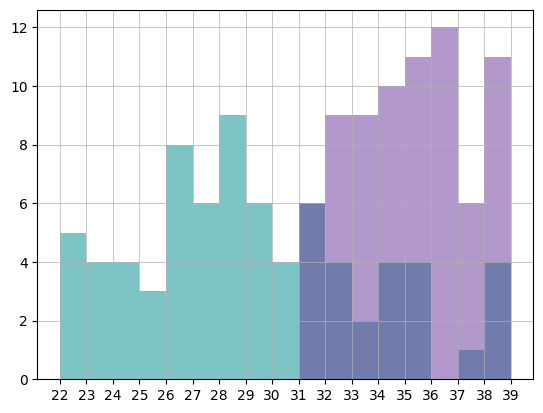

In [52]:
plt.hist(Ek_summer.week_of_year.sel(time = Ek_sub_summer), color = 'darkcyan', bins = np.arange(22, 40, 1), alpha = 0.5)
plt.hist(SST_summer.week_of_year.sel(time = SST_sub_summer), color = 'rebeccapurple', bins = np.arange(22, 40, 1), alpha = 0.5)
plt.grid(lw = 0.5)
plt.xticks(np.arange(22, 40, 1));

In [53]:
## not really sure what this does
stats.kstest(Ek_summer.sel(time = Ek_sub_summer).time.dt.year, stats.randint.cdf(np.unique(Ek_summer.time.dt.year.values), 1982, 2022))

KstestResult(statistic=1.0, pvalue=7.566056842000338e-32, statistic_location=1.0, statistic_sign=-1)

In [54]:
SST_year = np.empty(41)
SST_year.fill(np.nan)
Ek_year = np.empty(41)
Ek_year.fill(np.nan)

SST_years = SST_summer.sel(time = SST_sub_summer).time.dt.year
Ek_years = Ek_summer.sel(time = Ek_sub_summer).time.dt.year

years = np.arange(1982, 2023)
for i in np.arange(41):
    SST_year[i] = (SST_years == years[i]).sum()
    Ek_year[i] = (Ek_years == years[i]).sum()
    

(1980.0, 2024.0)

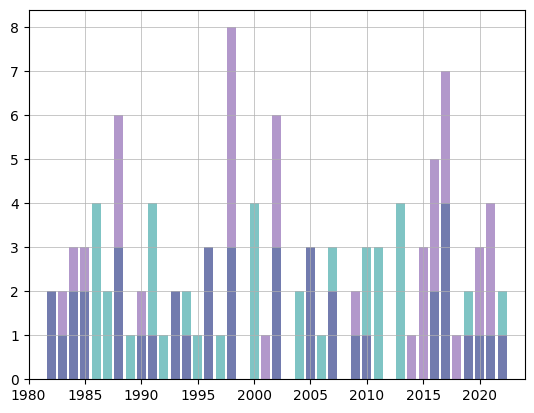

In [55]:
plt.bar(years, Ek_year, color = 'darkcyan', alpha = 0.5)
plt.bar(years, SST_year, color = 'rebeccapurple', alpha = 0.5)
plt.grid(lw = 0.5)
plt.xlim(1980, 2024)

In [56]:
x = np.empty(41)
x.fill(sum(Ek_year)/41)  # expected occurence of upwelling events per year 

In [57]:
stats.chisquare(SST_year, x) # SST is significantly different from random (I tink)

Power_divergenceResult(statistic=98.86486486486486, pvalue=6.847653556934075e-07)

In [58]:
stats.chisquare(Ek_year, x) # Ek is not significantly different from random (I think)

Power_divergenceResult(statistic=37.91891891891892, pvalue=0.5643015171224002)

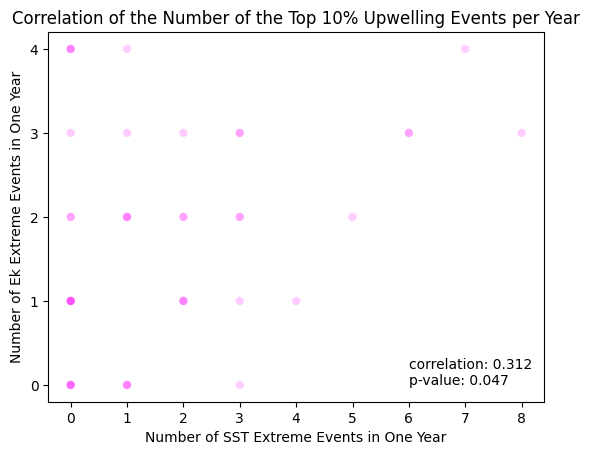

In [59]:
plt.scatter(SST_year, Ek_year, color = 'magenta', alpha = 0.2, edgecolors = 'none')
plt.yticks([0,1,2,3,4])
plt.xticks([0,1,2,3,4,5,6,7,8])
plt.ylabel('Number of Ek Extreme Events in One Year')
plt.xlabel('Number of SST Extreme Events in One Year')
plt.title('Correlation of the Number of the Top 10% Upwelling Events per Year')

result = pearsonr(Ek_year, SST_year)
plt.text(6, 0, f'correlation: {result[0]:.3f} \np-value: {result[1]:.3f}');
plt.savefig('Correlation_of_extremes_per_year.png', dpi = 300, bbox_inches = 'tight')

In [60]:
SST_month = np.zeros(4)
Ek_month = np.zeros(4)

months = ['Jun', 'Jul', 'Aug', 'Sep']
for i in np.arange(4):
    SST_month[i] = (SST_summer.month.sel(time = SST_sub_summer).values == months[i]).sum()
    Ek_month[i] = (Ek_summer.month.sel(time = Ek_sub_summer).values == months[i]).sum()
    

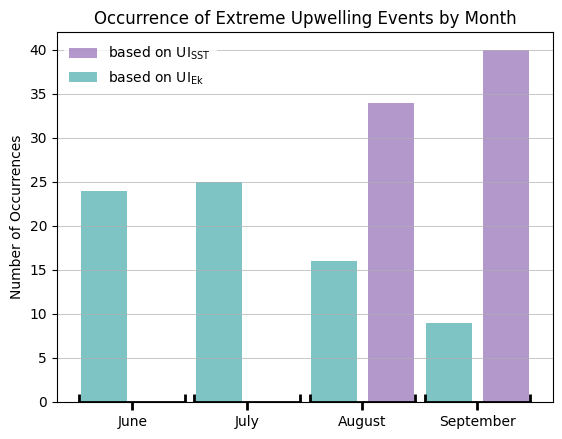

In [61]:
plt.bar([2, 4, 6, 8], SST_month, color = 'rebeccapurple', alpha = 0.5, label = r'based on $\rm UI_{SST}$')
plt.bar([1, 3, 5, 7], Ek_month, color = 'darkcyan', alpha = 0.5, label = r'based on $\rm UI_{Ek}$')
plt.grid(lw = 0.5, axis = 'y')

# get x-axis to show clearly which bars belong together
plt.plot([0.58, 2.42], [0, 0], lw = 2, color = 'k')
plt.plot([2.58, 4.42], [0, 0], lw = 2, color = 'k')
plt.plot([4.58, 6.42], [0, 0], lw = 2, color = 'k')
plt.plot([6.58, 8.42], [0, 0], lw = 2, color = 'k')
plt.xticks(ticks = [1.5, 3.5, 5.5, 7.5], labels = ['June', 'July', 'August', 'September'])
plt.xticks(minor = True, ticks = [0.58, 2.42, 2.58, 4.42, 4.58, 6.42, 6.58, 8.42])
plt.tick_params(which = 'minor', direction='in', length=6, width=2)
plt.tick_params(axis = 'x', length=6, width=2, grid_alpha=0.5)

plt.legend( edgecolor = 'none', facecolor = 'white') # bbox_to_anchor = (1,1), loc = 'upper left'
plt.title('Occurrence of Extreme Upwelling Events by Month')
plt.ylabel('Number of Occurrences')
plt.savefig('Extreme_by_month.png', dpi = 300, bbox_inches = 'tight')

In [62]:
Ek_month.sum()/4 # expected occurence of extreme weeks per month

18.5

In [63]:
stats.chisquare(Ek_month, [18.5, 18.5, 18.5, 18.5]) # significantly difference from random distribution (I think) (null-hypothesis of no difference is rejected for p-value < 0.05)

Power_divergenceResult(statistic=9.135135135135135, pvalue=0.02754711392714924)

In [64]:
stats.chisquare(SST_month, [18.5, 18.5, 18.5, 18.5]) # significantly different from random distributed (I think)

Power_divergenceResult(statistic=74.97297297297297, pvalue=3.67197065112711e-16)

## Composties (top 10%)

In [190]:
## Where both UI Ek and UI SST have top 10% weeks
Ek_comp = Ek_summer.sel(time = dup)[['ek_trans_u', 'ek_trans_v']].mean(dim = 'time') * 1000 # make it m3/s km
Ek_comp['magnitude'] = np.hypot(Ek_comp.ek_trans_u, Ek_comp.ek_trans_v) # probably trustworthy... compare to mag below
SST_comp = SST_summer.sel(time = dup).SST.mean(dim = 'time')
SLP_comp = SLP_summer.sel(time = dup).msl.where(SLP_summer.lsm).mean(dim = 'time') * 0.01 # make it hPa
SSH_comp = SSH_summer.sel(time = dup[np.where((dup > np.datetime64('1993-01-01')) & (dup < np.datetime64('2021-12-31')))]).zos.mean(dim = 'time') * 100 # make it cm

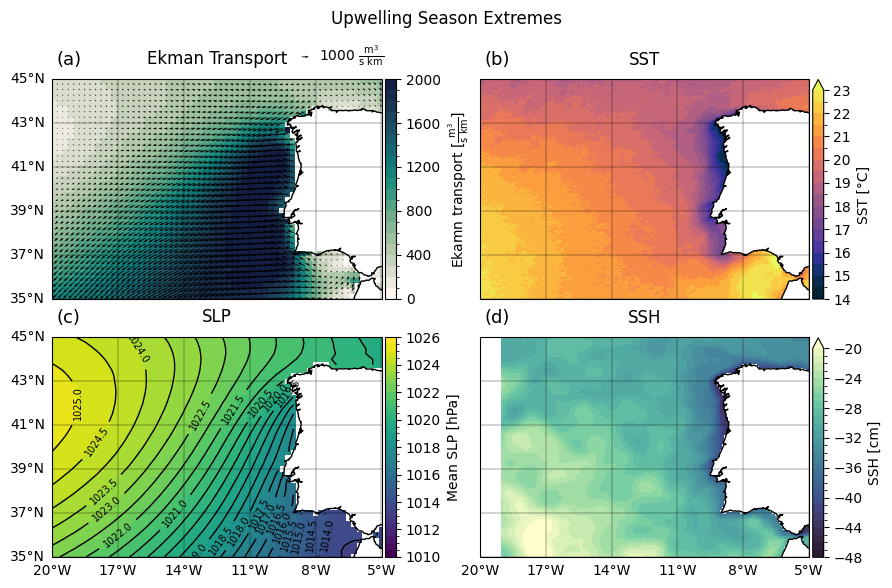

In [193]:
fig, ax = plt.subplots(2, 2, figsize = (9,6), subplot_kw={'projection': ccrs.PlateCarree()})
ax = ax.flatten()

# set up cartopy for all plots
for i in np.arange(4):
    ax[i].set_extent([-20.01, -4.99, 45.01, 34.99])
    ax[i].coastlines()
    gls = ax[i].gridlines(draw_labels=True, linewidth = 0.25, color = 'black')
    gls.top_labels = False 
    gls.right_labels = False
    gls.xlocator = mticker.FixedLocator(np.arange(-20, -4, 3))
    gls.ylocator = mticker.FixedLocator(np.arange(35, 46, 2))
    if i in (1, 3):
        gls.left_labels = False
    if i in (0, 1):
        gls.bottom_labels = False


#cp = Ek_comp.magnitude.plot(ax = ax[0], add_colorbar = False, cmap = cmo.tempo, vmin = 0, vmax = 2000, alpha = 0.8, levels = np.arange(0, 2100, 100))
mag = np.hypot(Ek_comp.ek_trans_u, Ek_comp.ek_trans_v)
cmap = cmo.tempo
norm = mcolors.BoundaryNorm(np.arange(0, 2100, 100), ncolors = cmap.N, clip = True)
cp = ax[0].imshow(mag, origin = 'lower', extent=[-20, -5, 35, 45], norm = norm, cmap = cmap)
im = ax[0].quiver(Ek_comp.lon, Ek_comp.lat, Ek_comp.ek_trans_u, Ek_comp.ek_trans_v, angles='xy', scale_units='xy', scale = 3*1000) #, clim = [0,2*1000]) 
plt.colorbar(cp, ax = ax[0], label = r'Ekamn transport [$\frac{\rm m^3}{\rm s \ km}$]', fraction = 0.0319, pad = 0.01, ticks = np.arange(0, 2400, 400));
ax[0].set_title('Ekman Transport')
ax[0].text(-19.8, 45.65, '(a)', fontsize = 13)
ax[0].quiverkey(im, 0.78, 1.1, 1*1000, r'1000 $\frac{\rm m^3}{\rm s \ km}$', labelpos='E')

cp = SST_comp.plot(ax = ax[1], add_colorbar = False, cmap = cmo.thermal, vmin = 14, vmax = 23, levels = np.arange(14, 23.5, 0.5))
plt.colorbar(cp, ax = ax[1], label = 'SST [°C]', fraction = 0.0319, pad = 0.01) 
ax[1].set_title('SST', pad = 10)
ax[1].text(-19.8, 45.65, '(b)', fontsize = 13)

cp = SLP_comp.plot(ax = ax[2], add_colorbar = False, cmap = 'viridis', vmin = 1010, vmax = 1026, levels = np.arange(1010, 1026.5, 0.5))
clp = SLP_comp.plot.contour(ax = ax[2], colors = 'black', linewidths = 1, levels = np.arange(1010, 1026.5, 0.5))
plt.colorbar(cp, ax = ax[2], label = 'Mean SLP [hPa]', fraction = 0.0319, pad = 0.01) 
plt.clabel(clp, fontsize = 7)
ax[2].set_title('SLP')
ax[2].text(-19.8, 45.65, '(c)', fontsize = 13)

cp = SSH_comp.plot(ax = ax[3], add_colorbar = False, cmap = cmo.deep_r, vmin = -48, vmax = -22, levels = np.arange(-48, -19, 1))
cbar = plt.colorbar(cp, ax = ax[3], label = 'SSH [cm]', fraction = 0.0319, pad = 0.01, ticks = np.arange(-48, -16, 4))
#cbar.ax.locator_params(nbins = 4)
ax[3].set_title('SSH', pad = 10)
ax[3].text(-19.8, 45.65, '(d)', fontsize = 13)

fig.suptitle(r'Upwelling Season Extremes')
fig.tight_layout(pad=1, w_pad=0, h_pad=-0.8)
fig.savefig('Upwelling_Season_Extremes.png', dpi = 300, bbox_inches = 'tight')

In [192]:
# min and max values overall 
print('Ek (combined) min:', Ek_comp.magnitude.min().values, 'max: ', Ek_comp.magnitude.max().values)
print('Ek (combined) min:', np.nanmin(mag.values), 'max: ', np.nanmax(mag.values))
print('SST min: ', SST_comp.min().values, 'max: ', SST_comp.max().values)
print('SLP min: ', SLP_comp.min().values, 'max: ', SLP_comp.max().values)
print('SSH min: ', SSH_comp.min().values, 'max: ', SSH_comp.max().values)

Ek (combined) min: 4.8083065356574375 max:  2160.191623606435
Ek (combined) min: 4.8083065356574375 max:  2160.191623606435
SST min:  14.273333333333335 max:  23.623333333333335
SLP min:  1013.31506 max:  1025.2432
SSH min:  -45.28889103999569 max:  -17.653969092486754


In [175]:
## SST
Ek_comp_SST = Ek_summer.sel(time = SST_sub_summer)[['ek_trans_u', 'ek_trans_v']].mean(dim = 'time') * 1000 # make it m3/s km
Ek_comp_SST['magnitude'] = np.hypot(Ek_comp_SST.ek_trans_u, Ek_comp_SST.ek_trans_v) 
SST_comp_SST = SST_summer.sel(time = SST_sub_summer).SST.mean(dim = 'time')
SLP_comp_SST = SLP_summer.sel(time = SST_sub_summer).msl.where(SLP_summer.lsm).mean(dim = 'time') * 0.01 # make it hPa
SSH_comp_SST = SSH_summer.sel(time = SST_sub_summer[np.where((SST_sub_summer > np.datetime64('1993-01-01')) & (SST_sub_summer < np.datetime64('2021-12-31')))]).zos.mean(dim = 'time') * 100 # make it cm

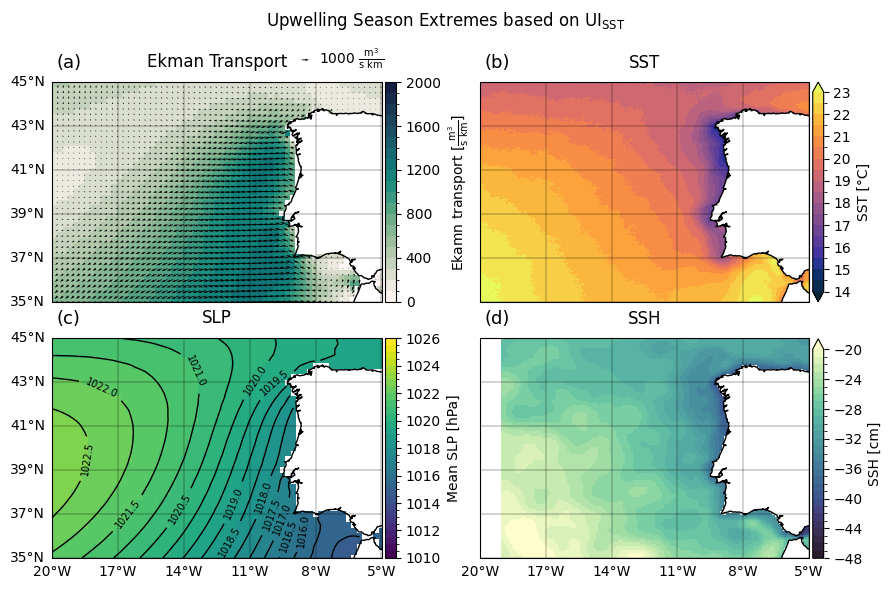

In [186]:
fig, ax = plt.subplots(2, 2, figsize = (9,6), subplot_kw={'projection': ccrs.PlateCarree()})
ax = ax.flatten()

# set up cartopy for all plots
for i in np.arange(4):
    ax[i].set_extent([-20.01, -4.99, 45.01, 34.99])
    ax[i].coastlines()
    gls = ax[i].gridlines(draw_labels=True, linewidth = 0.25, color = 'black')
    gls.top_labels = False 
    gls.right_labels = False
    gls.xlocator = mticker.FixedLocator(np.arange(-20, -4, 3))
    gls.ylocator = mticker.FixedLocator(np.arange(35, 46, 2))
    if i in (1, 3):
        gls.left_labels = False
    if i in (0, 1):
        gls.bottom_labels = False


#cp = Ek_comp_SST.magnitude.plot(ax = ax[0], add_colorbar = False, cmap = cmo.tempo, vmin = 0, vmax = 2000, alpha = 0.8, levels = np.arange(0, 2100, 100))
mag = np.hypot(Ek_comp_SST.ek_trans_u, Ek_comp_SST.ek_trans_v)
cmap = cmo.tempo
norm = mcolors.BoundaryNorm(np.arange(0, 2100, 100), ncolors = cmap.N, clip = True)
cp = ax[0].imshow(mag, origin = 'lower', extent=[-20, -5, 35, 45], norm = norm, cmap = cmap)
im = ax[0].quiver(Ek_comp_SST.lon, Ek_comp_SST.lat, Ek_comp_SST.ek_trans_u, Ek_comp_SST.ek_trans_v, angles='xy', scale_units='xy', scale = 3*1000) #, clim = [0,2*1000]) 
plt.colorbar(cp, ax = ax[0], label = r'Ekamn transport [$\frac{\rm m^3}{\rm s \ km}$]', fraction = 0.0319, pad = 0.01, ticks = np.arange(0, 2400, 400));
ax[0].set_title('Ekman Transport')
ax[0].text(-19.8, 45.65, '(a)', fontsize = 13)
ax[0].quiverkey(im, 0.78, 1.1, 1*1000, r'1000 $\frac{\rm m^3}{\rm s \ km}$', labelpos='E')

cp = SST_comp_SST.plot(ax = ax[1], add_colorbar = False, cmap = cmo.thermal, vmin = 14, vmax = 23, levels = np.arange(14, 23.5, 0.5))
plt.colorbar(cp, ax = ax[1], label = 'SST [°C]', fraction = 0.0319, pad = 0.01) 
ax[1].set_title('SST', pad = 10)
ax[1].text(-19.8, 45.65, '(b)', fontsize = 13)

cp = SLP_comp_SST.plot(ax = ax[2], add_colorbar = False, cmap = 'viridis', vmin = 1010, vmax = 1026, levels = np.arange(1010, 1026.5, 0.5))
clp = SLP_comp_SST.plot.contour(ax = ax[2], colors = 'black', linewidths = 1, levels = np.arange(1010, 1026.5, 0.5))
plt.colorbar(cp, ax = ax[2], label = 'Mean SLP [hPa]', fraction = 0.0319, pad = 0.01) 
plt.clabel(clp, fontsize = 7)
ax[2].set_title('SLP')
ax[2].text(-19.8, 45.65, '(c)', fontsize = 13)

cp = SSH_comp_SST.plot(ax = ax[3], add_colorbar = False, cmap = cmo.deep_r, vmin = -48, vmax = -22, levels = np.arange(-48, -19, 1))
cbar = plt.colorbar(cp, ax = ax[3], label = 'SSH [cm]', fraction = 0.0319, pad = 0.01, ticks = np.arange(-48, -16, 4))
#cbar.ax.locator_params(nbins = 4)
ax[3].set_title('SSH', pad = 10)
ax[3].text(-19.8, 45.65, '(d)', fontsize = 13)

fig.suptitle(r'Upwelling Season Extremes based on UI$_{\rm SST}$')
fig.tight_layout(pad=1, w_pad=0, h_pad=-0.8)
fig.savefig('Upwelling_Season_Extremes_SST.png', dpi = 300, bbox_inches = 'tight')

In [177]:
# min and max values overall 
print('Ek (combined) min:', Ek_comp_SST.magnitude.min().values, 'max: ', Ek_comp_SST.magnitude.max().values)
print('Ek (combined) min:', np.nanmin(mag.values), 'max: ', np.nanmax(mag.values))
print('SST min: ', SST_comp_SST.min().values, 'max: ', SST_comp_SST.max().values)
print('SLP min: ', SLP_comp_SST.min().values, 'max: ', SLP_comp_SST.max().values)
print('SSH min: ', SSH_comp_SST.min().values, 'max: ', SSH_comp_SST.max().values)

Ek (combined) min: 17.332977716423912 max:  1257.3016268860085
Ek (combined) min: 17.332977716423912 max:  1257.3016268860085
SST min:  13.914999999999997 max:  22.225135135135144
SLP min:  1014.6784 max:  1025.5966
SSH min:  -42.66031948657381 max:  -23.455686245280596


In [187]:
## Ek
Ek_comp_Ek = Ek_summer.sel(time = Ek_sub_summer)[['ek_trans_u', 'ek_trans_v']].mean(dim = 'time') * 1000 # make it m3/s km
Ek_comp_Ek['magnitude'] = np.hypot(Ek_comp_Ek.ek_trans_u, Ek_comp_Ek.ek_trans_v) # probably trustworthy... compare to mag below
SST_comp_Ek = SST_summer.sel(time = Ek_sub_summer).SST.mean(dim = 'time')
SLP_comp_Ek = SLP_summer.sel(time = Ek_sub_summer).msl.where(SLP_summer.lsm).mean(dim = 'time') * 0.01 # make it hPa
SSH_comp_Ek = SSH_summer.sel(time = Ek_sub_summer[np.where((Ek_sub_summer > np.datetime64('1993-01-01')) & (Ek_sub_summer < np.datetime64('2021-12-31')))]).zos.mean(dim = 'time') * 100 # make it cm

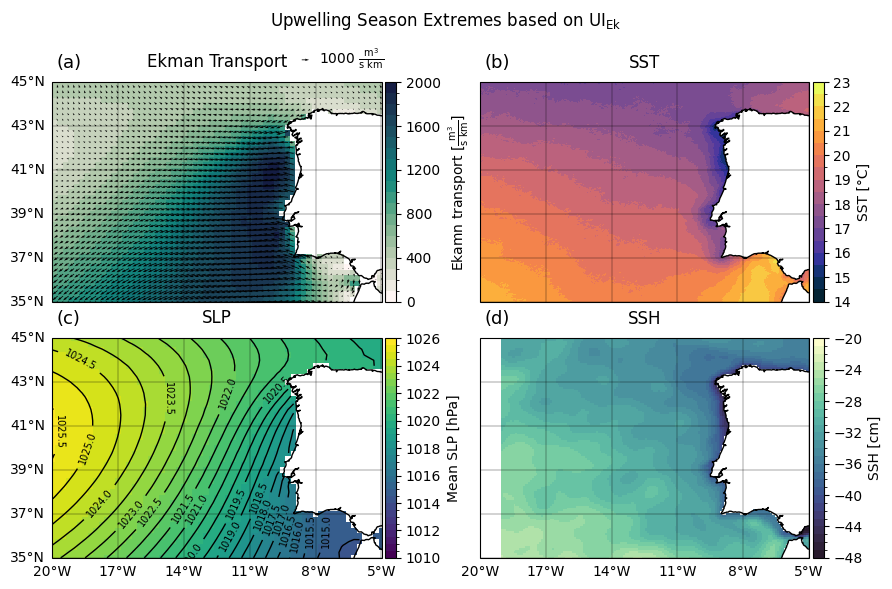

In [188]:
fig, ax = plt.subplots(2, 2, figsize = (9,6), subplot_kw={'projection': ccrs.PlateCarree()})
ax = ax.flatten()

# set up cartopy for all plots
for i in np.arange(4):
    ax[i].set_extent([-20.01, -4.99, 45.01, 34.99])
    ax[i].coastlines()
    gls = ax[i].gridlines(draw_labels=True, linewidth = 0.25, color = 'black')
    gls.top_labels = False 
    gls.right_labels = False
    gls.xlocator = mticker.FixedLocator(np.arange(-20, -4, 3))
    gls.ylocator = mticker.FixedLocator(np.arange(35, 46, 2))
    if i in (1, 3):
        gls.left_labels = False
    if i in (0, 1):
        gls.bottom_labels = False


#cp = Ek_comp_Ek.magnitude.plot(ax = ax[0], add_colorbar = False, cmap = cmo.tempo, vmin = 0, vmax = 2000, alpha = 0.8, levels = np.arange(0, 2100, 100))
mag = np.hypot(Ek_comp_Ek.ek_trans_u, Ek_comp_Ek.ek_trans_v)
cmap = cmo.tempo
norm = mcolors.BoundaryNorm(np.arange(0, 2100, 100), ncolors = cmap.N, clip = True)
cp = ax[0].imshow(mag, origin = 'lower', extent=[-20, -5, 35, 45], norm = norm, cmap = cmap)
im = ax[0].quiver(Ek_comp_Ek.lon, Ek_comp_Ek.lat, Ek_comp_Ek.ek_trans_u, Ek_comp_Ek.ek_trans_v, angles='xy', scale_units='xy', scale = 3*1000) #, clim = [0,2*1000]) 
plt.colorbar(cp, ax = ax[0], label = r'Ekamn transport [$\frac{\rm m^3}{\rm s \ km}$]', fraction = 0.0319, pad = 0.01, ticks = np.arange(0, 2400, 400));
ax[0].set_title('Ekman Transport')
ax[0].text(-19.8, 45.65, '(a)', fontsize = 13)
ax[0].quiverkey(im, 0.78, 1.1, 1*1000, r'1000 $\frac{\rm m^3}{\rm s \ km}$', labelpos='E')

cp = SST_comp_Ek.plot(ax = ax[1], add_colorbar = False, cmap = cmo.thermal, vmin = 14, vmax = 23, levels = np.arange(14, 23.5, 0.5))
plt.colorbar(cp, ax = ax[1], label = 'SST [°C]', fraction = 0.0319, pad = 0.01) 
ax[1].set_title('SST', pad = 10)
ax[1].text(-19.8, 45.65, '(b)', fontsize = 13)

cp = SLP_comp_Ek.plot(ax = ax[2], add_colorbar = False, cmap = 'viridis', vmin = 1010, vmax = 1026, levels = np.arange(1010, 1026.5, 0.5))
clp = SLP_comp_Ek.plot.contour(ax = ax[2], colors = 'black', linewidths = 1, levels = np.arange(1010, 1026.5, 0.5))
plt.colorbar(cp, ax = ax[2], label = 'Mean SLP [hPa]', fraction = 0.0319, pad = 0.01) 
plt.clabel(clp, fontsize = 7)
ax[2].set_title('SLP')
ax[2].text(-19.8, 45.65, '(c)', fontsize = 13)

cp = SSH_comp_Ek.plot(ax = ax[3], add_colorbar = False, cmap = cmo.deep_r, vmin = -48, vmax = -22, levels = np.arange(-48, -19, 1))
cbar = plt.colorbar(cp, ax = ax[3], label = 'SSH [cm]', fraction = 0.0319, pad = 0.01, ticks = np.arange(-48, -16, 4))
#cbar.ax.locator_params(nbins = 4)
ax[3].set_title('SSH', pad = 10)
ax[3].text(-19.8, 45.65, '(d)', fontsize = 13)

fig.suptitle(r'Upwelling Season Extremes based on UI$_{\rm Ek}$')
fig.tight_layout(pad=1, w_pad=0, h_pad=-0.8)
fig.savefig('Upwelling_Season_Extremes_Ek.png', dpi = 300, bbox_inches = 'tight')

In [189]:
# min and max values overall 
print('Ek (combined) min:', Ek_comp_Ek.magnitude.min().values, 'max: ', Ek_comp_Ek.magnitude.max().values)
print('Ek (combined) min:', np.nanmin(mag.values), 'max: ', np.nanmax(mag.values))
print('SST min: ', SST_comp_Ek.min().values, 'max: ', SST_comp_Ek.max().values)
print('SLP min: ', SLP_comp_Ek.min().values, 'max: ', SLP_comp_Ek.max().values)
print('SSH min: ', SSH_comp_Ek.min().values, 'max: ', SSH_comp_Ek.max().values)

Ek (combined) min: 15.289371823932797 max:  1942.7327581007844
Ek (combined) min: 15.289371823932797 max:  1942.7327581007844
SST min:  14.803513513513513 max:  22.225135135135144
SLP min:  1014.2587 max:  1025.5966
SSH min:  -47.276387085157936 max:  -23.455686245280596


## SM Angles

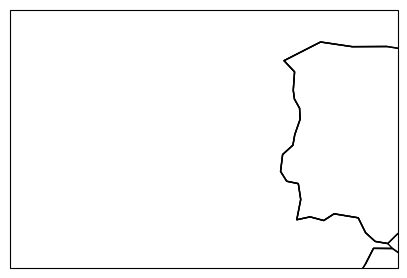

In [68]:
## Create a map projection and extract lat and lon values of coastline 
# adapted from chatGPT
projection = ccrs.PlateCarree()

# Create a figure and add axes with the specified projection
fig, ax = plt.subplots(figsize=(5, 5), subplot_kw={'projection': projection})

# Set the geographical extent of the plot to the region of interest
ax.set_extent([-20, -5, 35, 45], crs=projection)
ax.coastlines(resolution='110m')  # Set resolution to '50m'

# Add a feature for the coastlines to extract the coordinates
coastlines = cfeature.NaturalEarthFeature(
    'physical', 'coastline', '110m', edgecolor='k', facecolor='none')  # Set resolution to '50m'

ax.add_feature(coastlines)

# Initialize lists to store coordinates
longitudes = []
latitudes = []

# Extract and plot the coordinates of the coastlines
def plot_and_collect_coords(geometry):
    if isinstance(geometry, (LineString, MultiLineString)):
        if isinstance(geometry, LineString):
            geometries = [geometry]
        else:
            geometries = geometry.geoms
        
        for geom in geometries:
            x, y = geom.xy
            for lon, lat in zip(x, y):
                if -20 <= lon <= -5 and 35 <= lat <= 45:
                    longitudes.append(lon)
                    latitudes.append(lat)

for geometry in coastlines.geometries():
    plot_and_collect_coords(geometry)

# Convert lists to numpy arrays
longitudes = np.array(longitudes)
latitudes = np.array(latitudes)

coords = np.column_stack((longitudes, latitudes))

# Plot the coordinates
ax.plot(longitudes, latitudes, 'k', linewidth=1)

# Display the plot
plt.show()


In [69]:
# get the points that lie in between the points where I want data later
# my logic is that I can assign the value that I calculated between 34.875 and 35.125 to 35 
# -> this makes sense because the value gives me the angle of the coast between these two latitudes i.e. at 35°N
lat_mid = np.arange(34.875, 45.125, 0.25) 
lon_mid = np.interp(lat_mid, coords[:,1], coords[:,0]) 

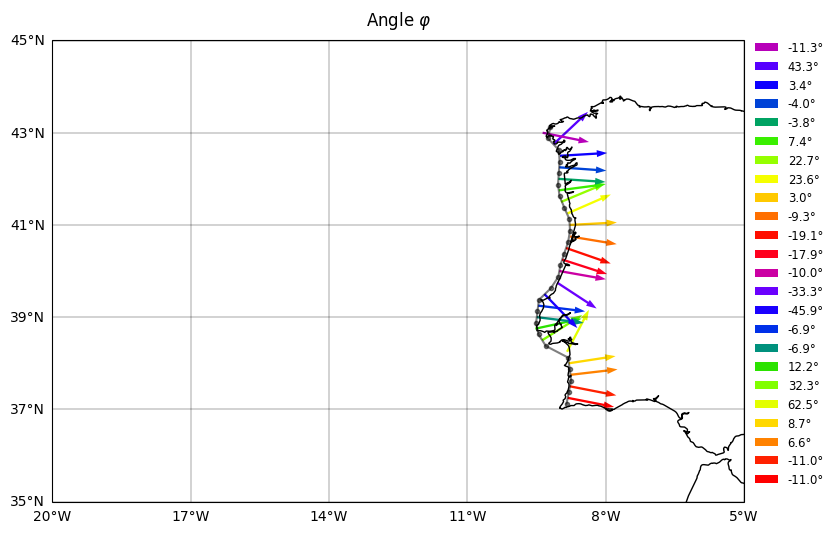

In [70]:
# Plotting

# get values only between 37.25 and 43
latitudes = Angles.lat.where((Angles.lat >= 37.25) & (Angles.lat <= 43))
longitudes = Angles.lon.where((Angles.lat >= 37.25) & (Angles.lat <= 43)).mean(dim = 'lat')
angles_rad = Angles.angle_phi.where((Angles.lat >= 37.25) & (Angles.lat <= 43))

plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-20.01, -4.99, 45.01, 34.99])
ax.coastlines()
ax.add_feature(cfeature.LAND, color = 'white', zorder = 0)
gls = ax.gridlines(draw_labels=True, linewidth = 0.25, color = 'black')
gls.top_labels = False 
gls.right_labels = False  
gls.xlocator = mticker.FixedLocator(np.arange(-20, -4, 3))
gls.ylocator = mticker.FixedLocator(np.arange(35, 46, 2))

# colors
cmap = plt.get_cmap("prism")

# Iterate through each position
i = 0
for lat, lon, angle_rad in zip(latitudes, longitudes, angles_rad):
    if (lat >= 37.25) & (lat <= 43):
        # Define line segment
        length = 0.8  # Length of the line segment
        dx = length * np.cos(angle_rad)
        dy = length * np.sin(angle_rad)
        lon2 = lon + dx
        lat2 = lat + dy
        # Plot line arrow
        plt.arrow(lon.values, lat.values, dx.values, dy.values, width = 0.05, edgecolor = 'none', facecolor = cmap(i), alpha = 1, 
                  label=f'{np.degrees(angle_rad):.1f}°')
        i = i + 2

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], fontsize = 'small', bbox_to_anchor = (1.13, 1.02), edgecolor = 'none')
plt.title(r'Angle $\varphi$')

plt.scatter(lon_mid[9:-7], lat_mid[9:-7], marker = '.', color = 'black', alpha = 0.5)
plt.plot(lon_mid[9:-7], lat_mid[9:-7], color = 'black', alpha = 0.5)

plt.savefig('Angle_phi.png', dpi = 300, bbox_inches = 'tight')

## SM monthly mean

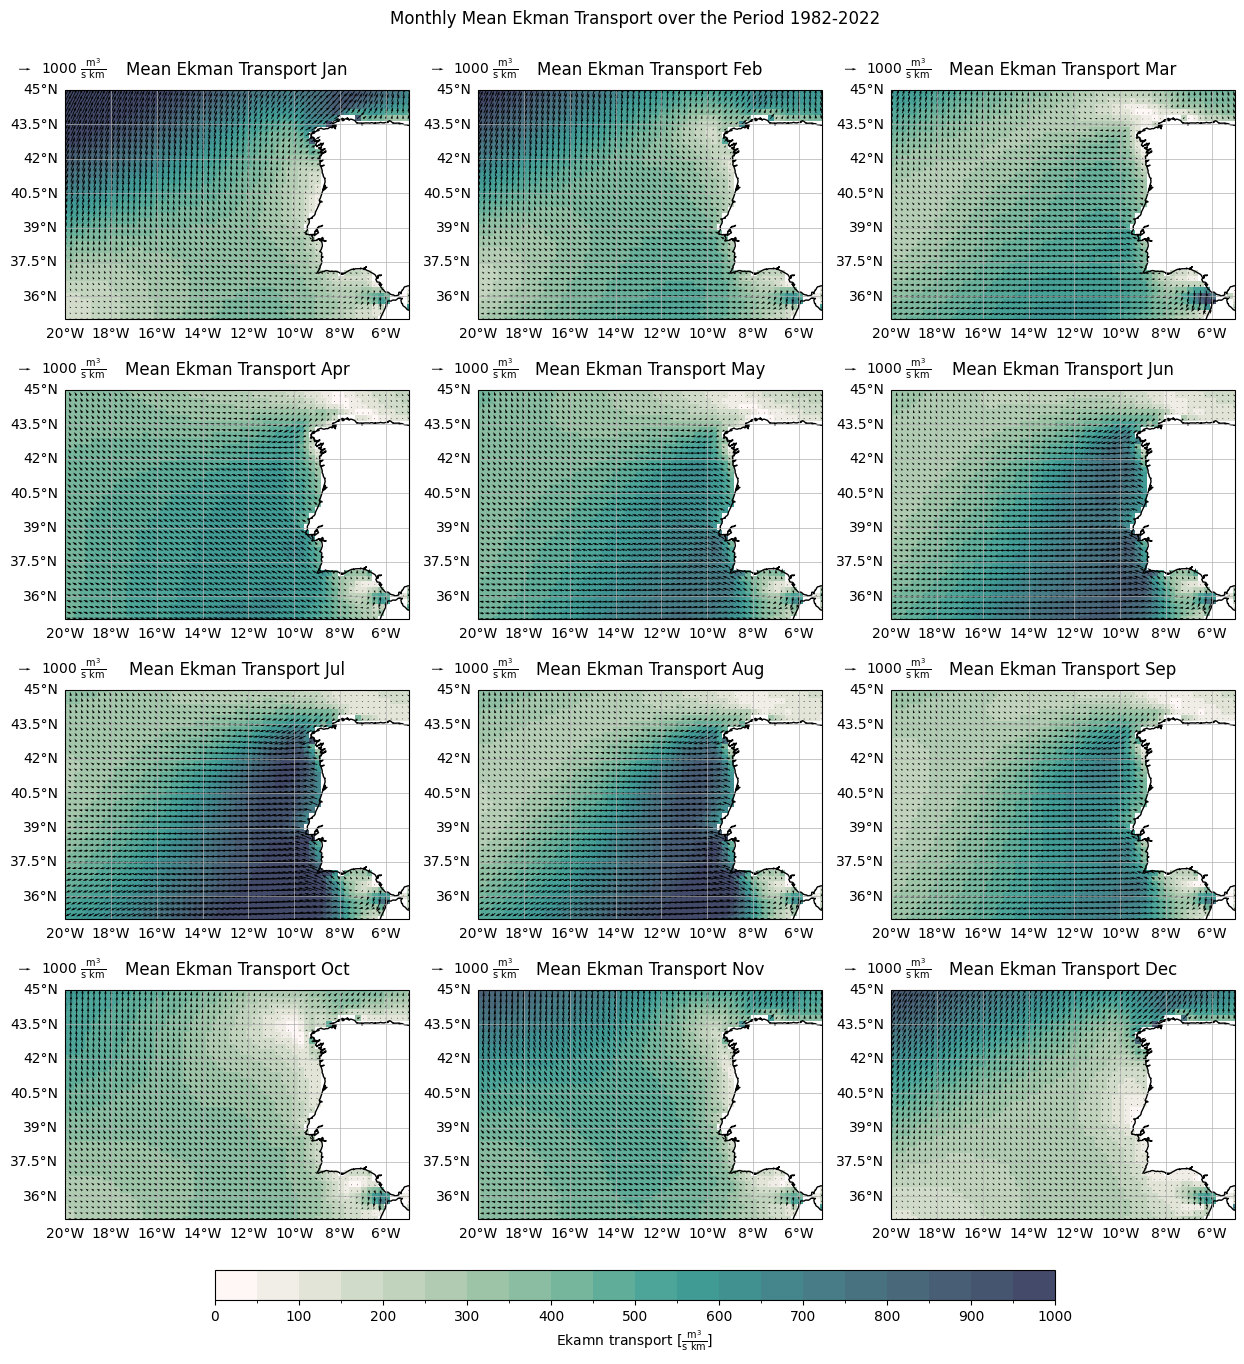

In [71]:
plot_monthly_means(Ek, Ek.month, Ek = True, main_title = 'Monthly Mean Ekman Transport over the Period 1982-2022', title = 'Ekman Transport', 
                   cmap = cmo.tempo, levels = np.arange(0, 1050, 50), save = save_var, save_fig_as = 'Map_monthly_mean_Ek')

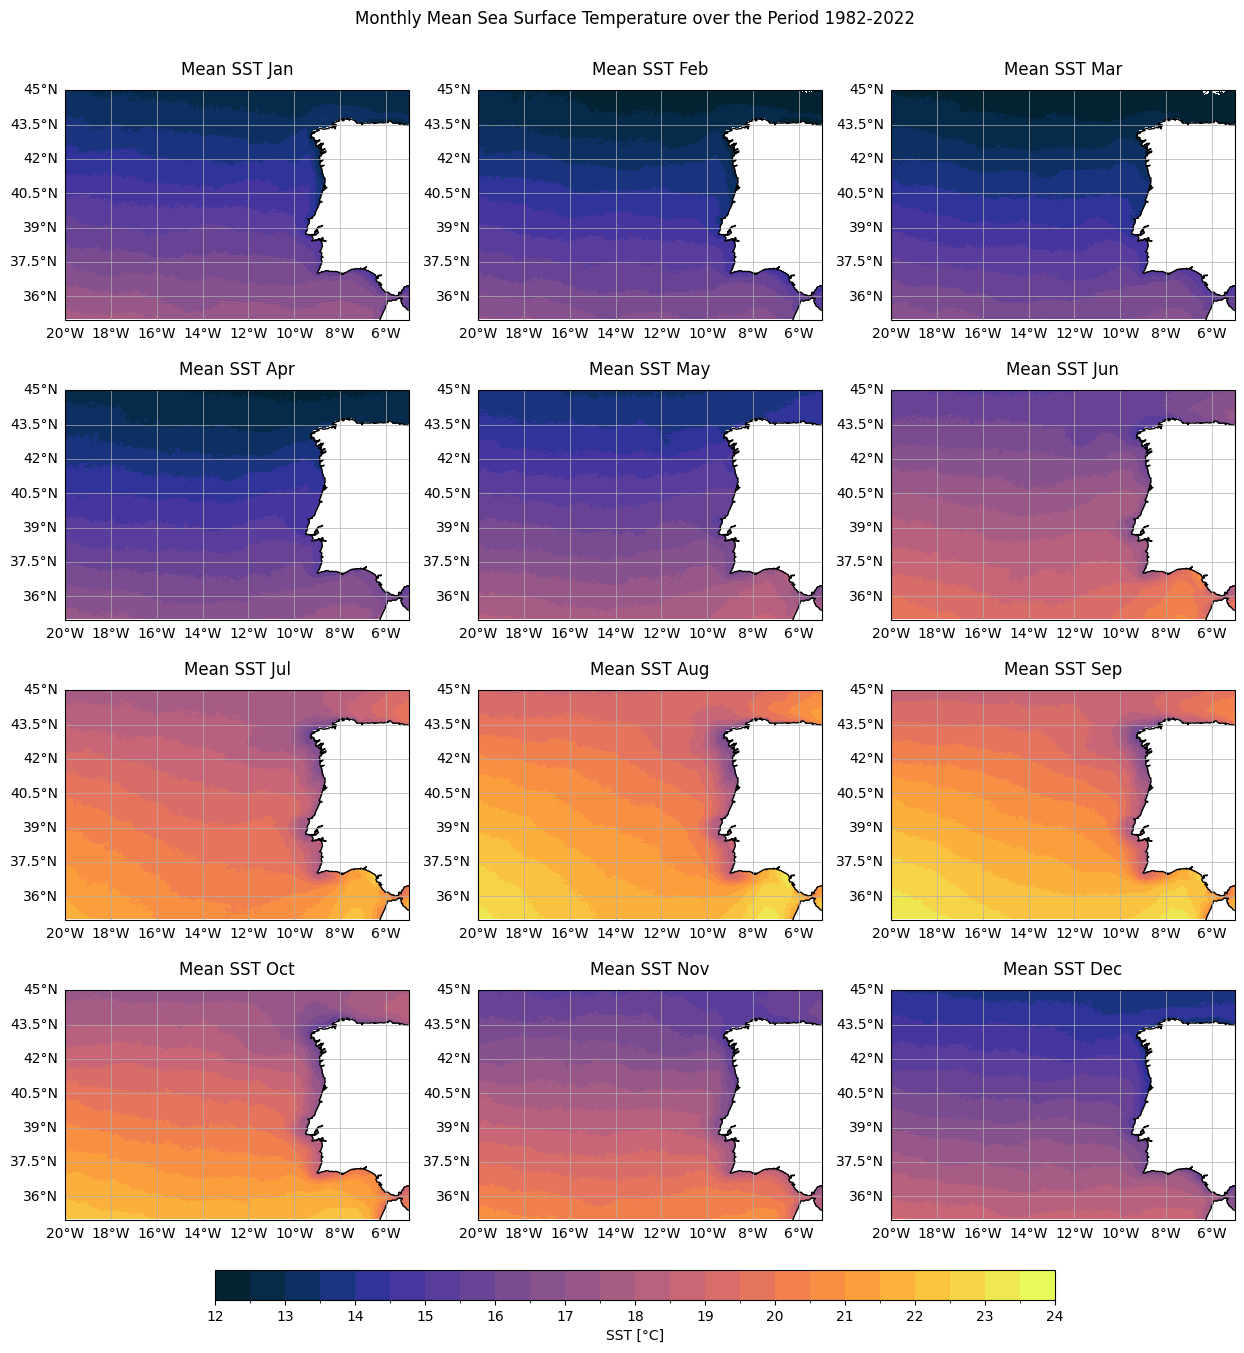

In [72]:
plot_monthly_means(SST.SST, SST.month,  main_title = 'Monthly Mean Sea Surface Temperature over the Period 1982-2022', title = 'SST', 
                   cmap = cmo.thermal, levels = np.arange(12, 24.5, 0.5), ticks = np.arange(12, 25), cbar_label = 'SST [°C]', 
                   save = save_var, save_fig_as = 'Map_monthly_mean_SST')

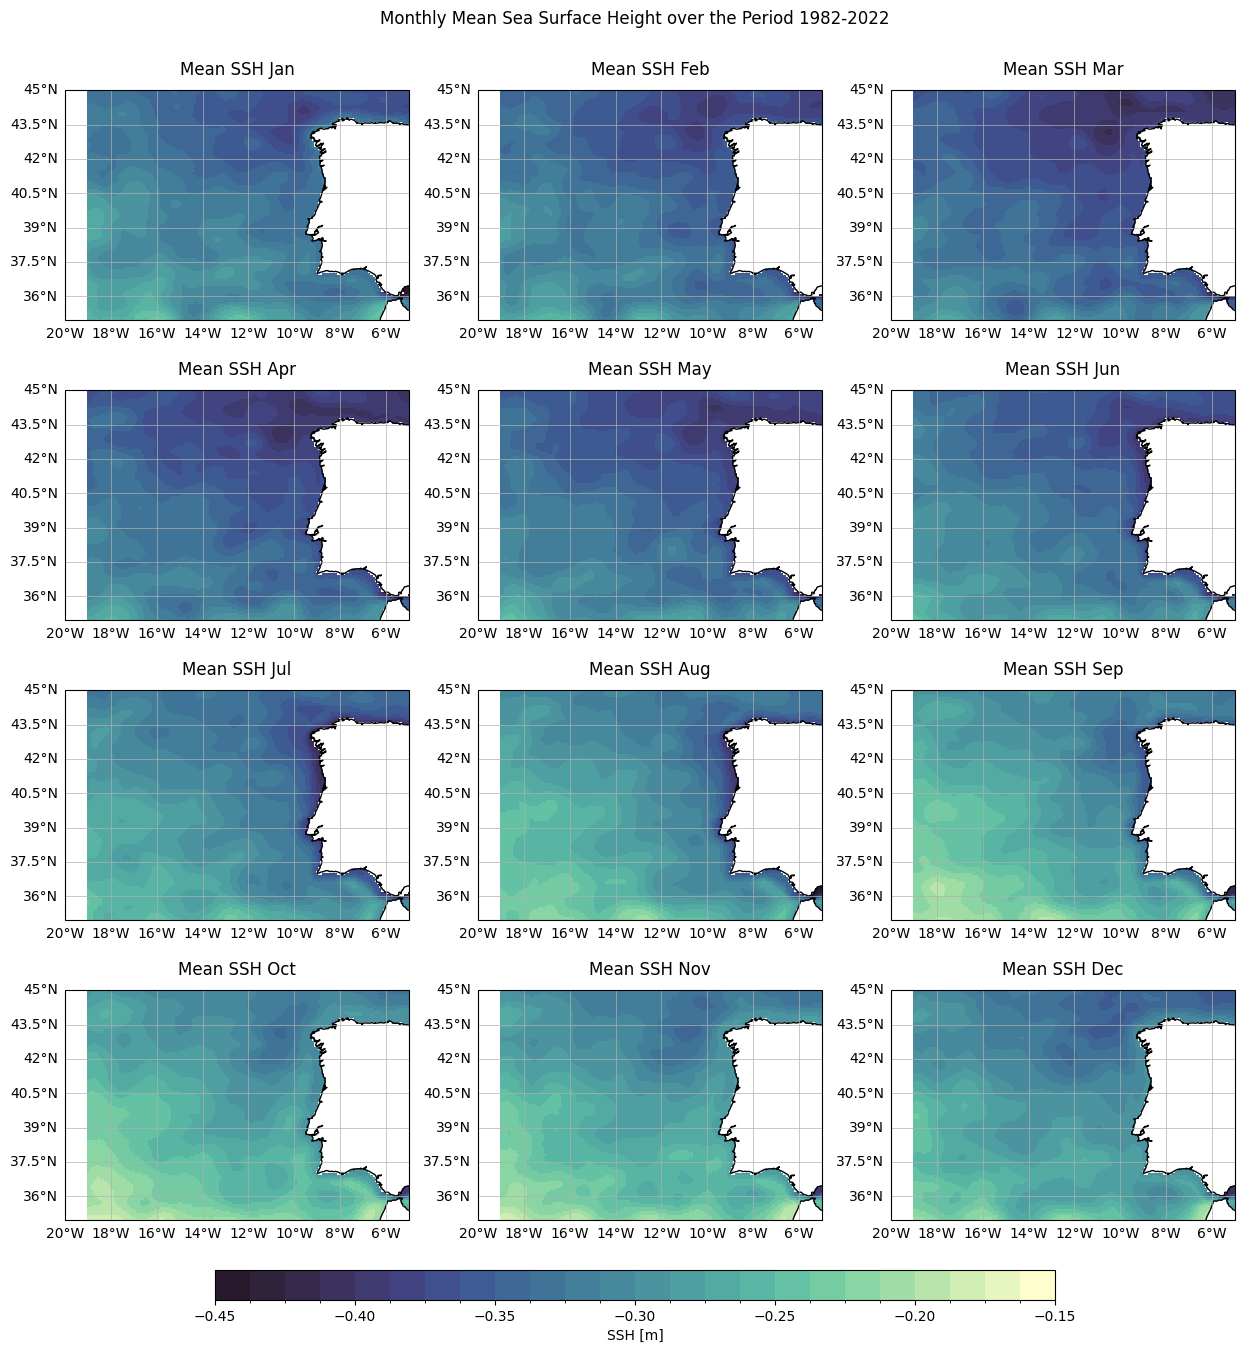

In [73]:
plot_monthly_means(SSH.zos, SST.month, main_title = 'Monthly Mean Sea Surface Height over the Period 1982-2022', title = 'SSH', 
                   cmap = cmo.deep_r, cbar_label = 'SSH [m]', levels = np.arange(-0.45, -0.1475, 0.0125), ticks = np.arange(-0.45, -0.1, 0.05),
                   save = save_var, save_fig_as = 'Map_monthly_mean_SSH')

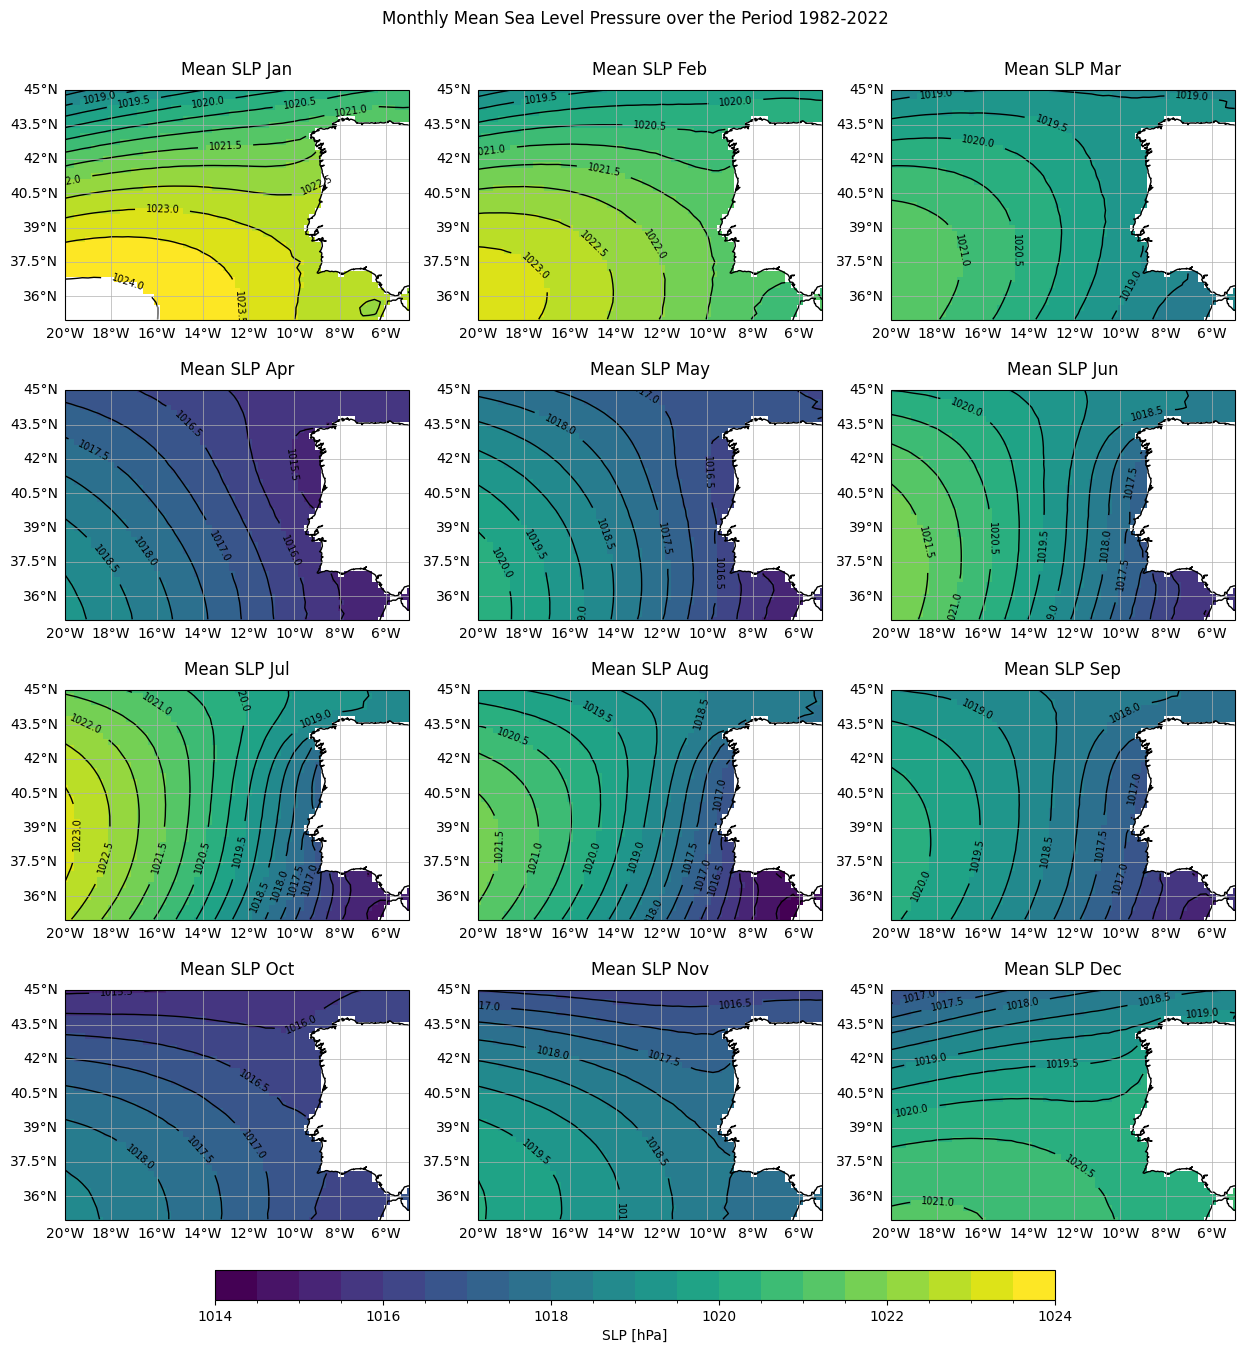

In [74]:
plot_monthly_means(SLP.msl.where(SLP.lsm) * 0.01, SLP.month, main_title = 'Monthly Mean Sea Level Pressure over the Period 1982-2022', title = 'SLP', 
                   levels = np.arange(1014, 1024.5, 0.5), ticks = np.arange(1014, 1026, 2), cbar_label = 'SLP [hPa]', cmap = 'viridis', add_contour = True,
                   save = save_var, save_fig_as = 'Map_monthly_mean_SLP')

## SM Upwelling Season Trend SST zoom in 

In [168]:
np.nanmin(SST_us_trend)

-0.12730381339527674

In [169]:
np.where(SST_us_trend == -0.12730381339527674)

(array([182]), array([268]))

In [171]:
print('location min SST trend (lat, lon)', SST.lat[182].values, SST.lon[268].values) 

location min SST trend (lat, lon) 42.594303 -8.811487


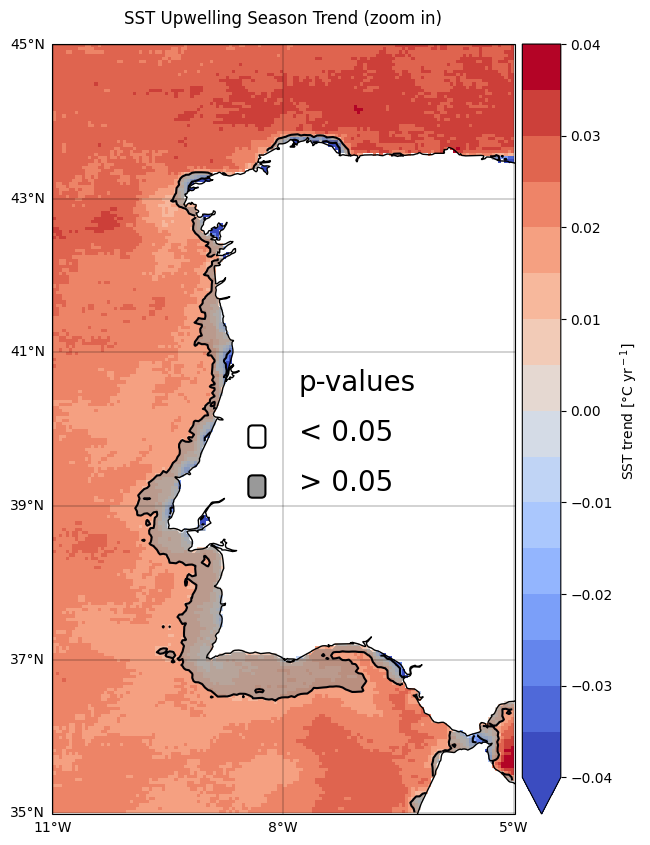

In [167]:
## SM SST (zoom in)
plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-11.01, -4.99, 45.01, 34.99])
ax.coastlines()
ax.add_feature(cfeature.LAND, color = 'white', zorder = 0)
gls = ax.gridlines(draw_labels=True, linewidth = 0.25, color = 'black')
gls.top_labels = False 
gls.right_labels = False  
gls.xlocator = mticker.FixedLocator(np.arange(-20, -4, 3))
gls.ylocator = mticker.FixedLocator(np.arange(35, 46, 2))

# min trend
#plt.scatter(-8.811487, 42.594303, color = 'red', zorder = 10);

cmap = plt.get_cmap('coolwarm')
norm = mcolors.BoundaryNorm(np.arange(-0.04, 0.045, 0.005), ncolors = cmap.N, clip = True)
cp = plt.imshow(SST_us_trend, origin = 'lower', cmap = cmap, extent=[-20, -5, 35, 45], norm = norm)
cb = plt.colorbar(cp, label = r'SST trend [°C yr$^{\rm -1}$]', fraction = 0.319, pad = 0.01, extend = 'min') 
cb.ax.minorticks_off()
plt.title('SST Upwelling Season Trend (zoom in)', pad = 10)

#sig_indices = np.where(SST_us_pvalues < sig_level)
#plt.scatter(SST_usm.lon[sig_indices[1]], SST_usm.lat[sig_indices[0]], color = 'k', s = 0.01)
plt.contour(SST_usm.lon, SST_usm.lat, SST_us_pvalues, [0.05], cmap = 'magma', linewidths = 1.5)
plt.contourf(SST_usm.lon, SST_usm.lat, SST_us_pvalues, [0.05, 1], cmap = 'binary', alpha = 0.5)

# legend
plt.text(-7.8, 40.5, s = 'p-values', fontsize = 20)
plt.text(-8.4, 39.85, s='  ', size = 10, bbox=dict(boxstyle="round", ec=(0, 0, 0), fc=(1, 1, 1), linewidth = 1.5))
plt.text(-7.8, 39.85, '< 0.05', fontsize = 20)
plt.text(-8.4, 39.2, s='  ', size = 10, bbox=dict(boxstyle="round", ec=(0, 0, 0), fc=(0.6, 0.6, 0.6), linewidth = 1.5))
plt.text(-7.8, 39.2, '> 0.05', fontsize = 20);

plt.savefig('Upwelling_Season_Trend_SST_zoom_in.png', dpi = 300, bbox_inches = 'tight')

## SM Upwelling Season Trend SLP extended

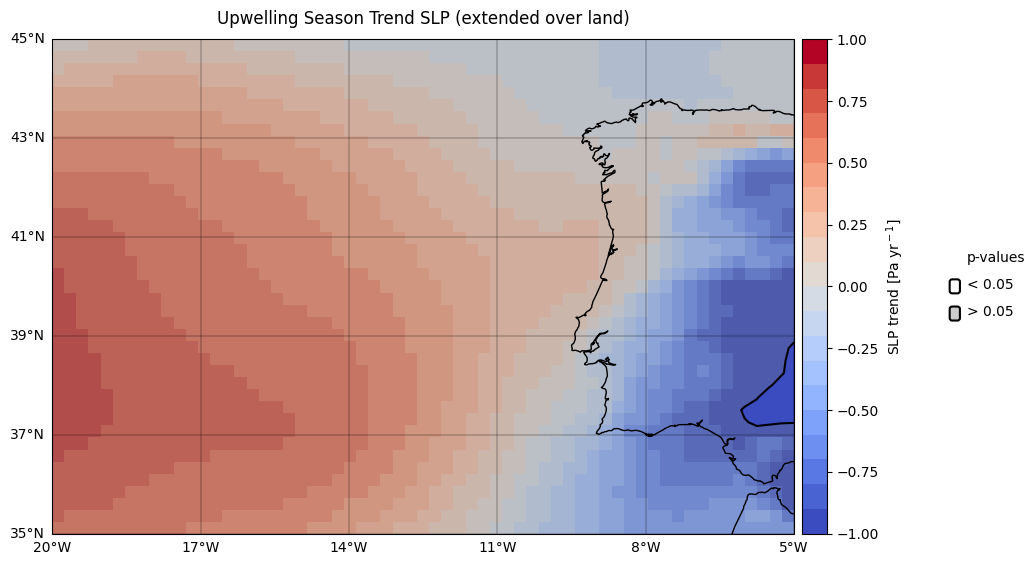

In [166]:
## SM SLP
SLP_us_trend_all, SLP_us_pvalues_all = calc_trend_and_significance(SLP_summer_mean.msl)

plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-20.01, -4.99, 45.01, 34.99])
ax.coastlines()
ax.add_feature(cfeature.LAND, color = 'white', zorder = 0)
gls = ax.gridlines(draw_labels=True, linewidth = 0.25, color = 'black')
gls.top_labels = False 
gls.right_labels = False  
gls.xlocator = mticker.FixedLocator(np.arange(-20, -4, 3))
gls.ylocator = mticker.FixedLocator(np.arange(35, 46, 2))


norm = mcolors.BoundaryNorm(np.arange(-1, 1.1, 0.1), ncolors = cmap.N, clip = True)
cp = plt.imshow(SLP_us_trend_all, origin = 'lower', cmap = cmap, extent=[-20, -5, 35, 45], norm = norm) 
cb = plt.colorbar(cp, label = r'SLP trend [Pa yr$^{\rm -1}$]', fraction = 0.0319, pad = 0.01, ticks = np.arange(-1, 1.25, 0.25))
cb.ax.minorticks_off()
plt.title('Upwelling Season Trend SLP (extended over land)')

plt.contour(SLP_usm.lon, SLP_usm.lat, SLP_us_pvalues_all, [0.05], cmap = 'magma', linewidths = 1.5)
plt.contourf(SLP_usm.lon, SLP_usm.lat, SLP_us_pvalues_all, [0.05, 1], cmap = 'binary', alpha = 0.3)

plt.text(-1.5, 40.5, s = 'p-values', fontsize = 10)
plt.text(-1.8, 39.95, s='  ', size = 6, bbox=dict(boxstyle="round", ec=(0, 0, 0), fc=(1, 1, 1), linewidth = 1.5))
plt.text(-1.5, 39.95, '< 0.05', fontsize = 10)
plt.text(-1.8, 39.4, s='  ', size = 6, bbox=dict(boxstyle="round", ec=(0, 0, 0), fc=(0.8, 0.8, 0.8), linewidth = 1.5))
plt.text(-1.5, 39.4, '> 0.05', fontsize = 10);

plt.savefig('Upwelling_Season_Trend_SLP_extended.png', dpi = 300, bbox_inches = 'tight')

## SM Temperature at 15°W and mid-shelf

In [79]:
# CoRTAD (short)
SST_summer_mean_x = SST_summer[['SST', 'mid_shelf']].resample(time = 'YE', label = 'left').mean(dim = 'time')
SST_15_off = my_functions.calc_meridional_mean(SST_summer_mean_x , variable = 'SST', lon = -15)
SST_mid_shelf = SST_summer_mean_x.where(SST_summer_mean_x.mid_shelf).SST.mean(dim = ['lat', 'lon'])

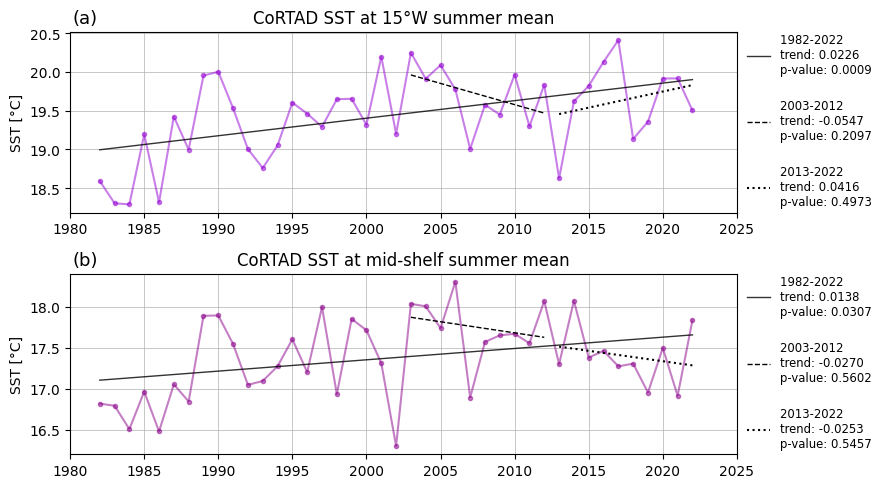

In [80]:
fig = plt.figure(figsize = (9, 5))
ax1 = plt.subplot(2,1,1)
plot_trend(SST_15_off.time, SST_15_off.SST_mean, col = 'darkviolet', title = r'CoRTAD SST at 15°W summer mean', 
           ylabel = r'SST [°C]', long = False)
ax1.text(3700, 20.63, '(a)', fontsize = 13) 
ax2 = plt.subplot(2,1,2)
plot_trend(SST_mid_shelf.time, SST_mid_shelf, col = 'darkmagenta', title = r'CoRTAD SST at mid-shelf summer mean', 
           ylabel = r'SST [°C]', long = False)
ax2.text(3700, 18.5, '(b)', fontsize = 13);
fig.savefig('SST_CoRTAD_short.png', dpi = 300, bbox_inches = 'tight')

In [81]:
# ERA5 (long)
ERA5_SST_summer_mean_x = ERA5_SST_summer.resample(time = 'YE', label = 'left').mean(dim = 'time')
ERA5_SST_15_off = my_functions.calc_meridional_mean(ERA5_SST_summer_mean_x , variable = 'SST', lon = -15)
ERA5_SST_mid_shelf = ERA5_SST_summer_mean_x.where(ERA5_SST_summer_mean_x.mid_shelf).SST.mean(dim = ['lat', 'lon'])

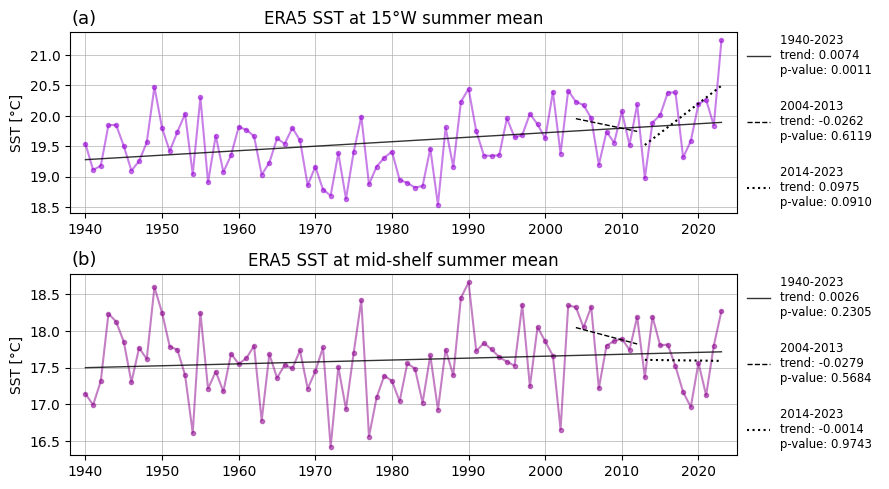

In [82]:
fig = plt.figure(figsize = (9, 5))
ax1 = plt.subplot(2,1,1)
plot_trend(ERA5_SST_15_off.time, ERA5_SST_15_off.SST_mean, col = 'darkviolet', title = r'ERA5 SST at 15°W summer mean', 
           ylabel = r'SST [°C]', long = True)
ax1.text(-11600, 21.51, '(a)', fontsize = 13) 
ax2 = plt.subplot(2,1,2)
plot_trend(ERA5_SST_mid_shelf.time, ERA5_SST_mid_shelf, col = 'darkmagenta', title = r'ERA5 SST at mid-shelf summer mean', 
           ylabel = r'SST [°C]', long = True)
ax2.text(-11600, 18.9, '(b)', fontsize = 13);
fig.savefig('SST_ERA5_long.png', dpi = 300, bbox_inches = 'tight')

## SM Composties (bottom 10%)

In [75]:
## Ekman
Ek_bottom_10_summer = Ek_summer.time.sortby(Ek_summer.UI_mean, ascending = False).values[round(Ek_summer.time.shape[0] * 0.9) : round(Ek_summer.time.shape[0] * 1)]

In [200]:
Ek_comp_bottom_Ek = Ek_summer.sel(time = Ek_bottom_10_summer)[['ek_trans_u', 'ek_trans_v']].mean(dim = 'time') * 1000 # make it m3/s km
Ek_comp_bottom_Ek['magnitude'] = np.hypot(Ek_comp.ek_trans_u, Ek_comp.ek_trans_v) # doesn't work properly...
SST_comp_bottom_Ek = SST_summer.sel(time = Ek_bottom_10_summer).SST.mean(dim = 'time')
SLP_comp_bottom_Ek = SLP_summer.sel(time = Ek_bottom_10_summer).msl.where(SLP_summer.lsm).mean(dim = 'time') * 0.01 # make it hPa
SSH_comp_bottom_Ek = SSH_summer.sel(time = Ek_bottom_10_summer[np.where((Ek_bottom_10_summer > np.datetime64('1993-01-01')) & (Ek_bottom_10_summer < np.datetime64('2021-12-31')))]).zos.mean(dim = 'time') * 100 # make it cm

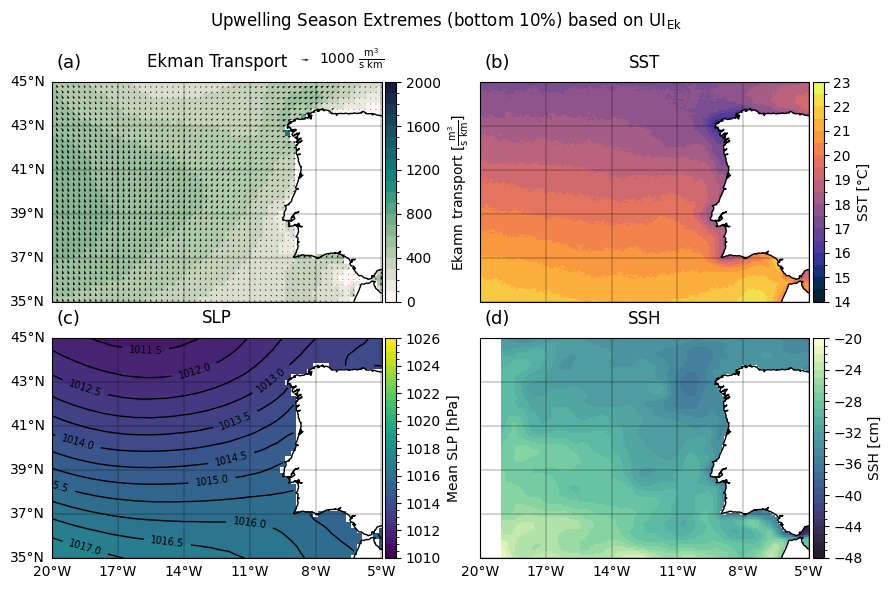

In [201]:
fig, ax = plt.subplots(2, 2, figsize = (9,6), subplot_kw={'projection': ccrs.PlateCarree()})
ax = ax.flatten()

# set up cartopy for all plots
for i in np.arange(4):
    ax[i].set_extent([-20.01, -4.99, 45.01, 34.99])
    ax[i].coastlines()
    gls = ax[i].gridlines(draw_labels=True, linewidth = 0.25, color = 'black')
    gls.top_labels = False 
    gls.right_labels = False
    gls.xlocator = mticker.FixedLocator(np.arange(-20, -4, 3))
    gls.ylocator = mticker.FixedLocator(np.arange(35, 46, 2))
    if i in (1, 3):
        gls.left_labels = False
    if i in (0, 1):
        gls.bottom_labels = False

#cp = Ek_comp_bottom_Ek.magnitude.plot(ax = ax[0], add_colorbar = False, cmap = cmo.tempo, vmin = 0, vmax = 2000, alpha = 0.8, levels = np.arange(0, 2100, 100))
mag_bottom = np.hypot(Ek_comp_bottom_Ek.ek_trans_u, Ek_comp_bottom_Ek.ek_trans_v)
cmap = cmo.tempo
norm = mcolors.BoundaryNorm(np.arange(0, 2100, 100), ncolors = cmap.N, clip = True)
cp = ax[0].imshow(mag_bottom, origin = 'lower', extent=[-20, -5, 35, 45], norm = norm, cmap = cmap)
im = ax[0].quiver(Ek_comp_bottom_Ek.lon, Ek_comp_bottom_Ek.lat, Ek_comp_bottom_Ek.ek_trans_u, Ek_comp_bottom_Ek.ek_trans_v, angles='xy', scale_units='xy', scale = 3*1000) #, clim = [0,2*1000]) 
plt.colorbar(cp, ax = ax[0], label = r'Ekamn transport [$\frac{\rm m^3}{\rm s \ km}$]', fraction = 0.0319, pad = 0.01, ticks = np.arange(0, 2400, 400));
ax[0].set_title('Ekman Transport')
ax[0].text(-19.8, 45.65, '(a)', fontsize = 13)
ax[0].quiverkey(im, 0.78, 1.1, 1*1000, r'1000 $\frac{\rm m^3}{\rm s \ km}$', labelpos='E')

cp = SST_comp_bottom_Ek.plot(ax = ax[1], add_colorbar = False, cmap = cmo.thermal, vmin = 14, vmax = 23, levels = np.arange(14, 23.5, 0.5))
plt.colorbar(cp, ax = ax[1], label = 'SST [°C]', fraction = 0.0319, pad = 0.01) 
ax[1].set_title('SST', pad = 10)
ax[1].text(-19.8, 45.65, '(b)', fontsize = 13)

cp = SLP_comp_bottom_Ek.plot(ax = ax[2], add_colorbar = False, cmap = 'viridis', vmin = 1010, vmax = 1026, levels = np.arange(1010, 1026.5, 0.5))
clp = SLP_comp_bottom_Ek.plot.contour(ax = ax[2], colors = 'black', linewidths = 1, levels = np.arange(1010, 1026.5, 0.5))
plt.colorbar(cp, ax = ax[2], label = 'Mean SLP [hPa]', fraction = 0.0319, pad = 0.01) 
plt.clabel(clp, fontsize = 7)
ax[2].set_title('SLP')
ax[2].text(-19.8, 45.65, '(c)', fontsize = 13)

cp = SSH_comp_bottom_Ek.plot(ax = ax[3], add_colorbar = False, cmap = cmo.deep_r, vmin = -48, vmax = -22, levels = np.arange(-48, -19, 1))
cbar = plt.colorbar(cp, ax = ax[3], label = 'SSH [cm]', fraction = 0.0319, pad = 0.01, ticks = np.arange(-48, -16, 4))
#cbar.ax.locator_params(nbins = 4)
ax[3].set_title('SSH', pad = 10)
ax[3].text(-19.8, 45.65, '(d)', fontsize = 13)

fig.suptitle(r'Upwelling Season Extremes (bottom 10%) based on UI$_{\rm Ek}$')
fig.tight_layout(pad=1, w_pad=0, h_pad=-0.8)
fig.savefig('Upwelling_Season_Extremes_bottom_Ek.png', dpi = 300, bbox_inches = 'tight')

In [78]:
# min and max values overall 
print('Ek (combined) min:', Ek_comp_bottom_Ek.magnitude.min().values, 'max: ', Ek_comp_bottom_Ek.magnitude.max().values)
print('Ek (combined) min:', np.nanmin(mag_bottom.values), 'max: ', np.nanmax(mag_bottom.values))
print('SST min: ', SST_comp_bottom_Ek.min().values, 'max: ', SST_comp_bottom_Ek.max().values)
print('SLP min: ', SLP_comp_bottom_Ek.min().values, 'max: ', SLP_comp_bottom_Ek.max().values)
print('SSH min: ', SSH_comp_bottom_Ek.min().values, 'max: ', SSH_comp_bottom_Ek.max().values)

Ek (combined) min: 15.289371823932797 max:  1942.7327581007844
Ek (combined) min: 28.9950072111708 max:  1105.5687261576884
SST min:  14.799864864864862 max:  22.323648648648646
SLP min:  1011.3335 max:  1017.46356
SSH min:  -45.550895020694156 max:  -21.313393869474694


In [194]:
# SST
SST_bottom_10_summer = SST_summer.time.sortby(SST_summer.UI_mean, ascending = False).values[round(SST_summer.time.shape[0] * 0.9) : round(SST_summer.time.shape[0] * 1)]

In [195]:
Ek_comp_bottom_SST = Ek_summer.sel(time = Ek_bottom_10_summer)[['ek_trans_u', 'ek_trans_v']].mean(dim = 'time') * 1000 # make it m3/s km
Ek_comp_bottom_SST['magnitude'] = np.hypot(Ek_comp.ek_trans_u, Ek_comp.ek_trans_v) # doesn't work properly...
SST_comp_bottom_SST = SST_summer.sel(time = Ek_bottom_10_summer).SST.mean(dim = 'time')
SLP_comp_bottom_SST = SLP_summer.sel(time = Ek_bottom_10_summer).msl.where(SLP_summer.lsm).mean(dim = 'time') * 0.01 # make it hPa
SSH_comp_bottom_SST = SSH_summer.sel(time = Ek_bottom_10_summer[np.where((Ek_bottom_10_summer > np.datetime64('1993-01-01')) & (Ek_bottom_10_summer < np.datetime64('2021-12-31')))]).zos.mean(dim = 'time') * 100 # make it cm

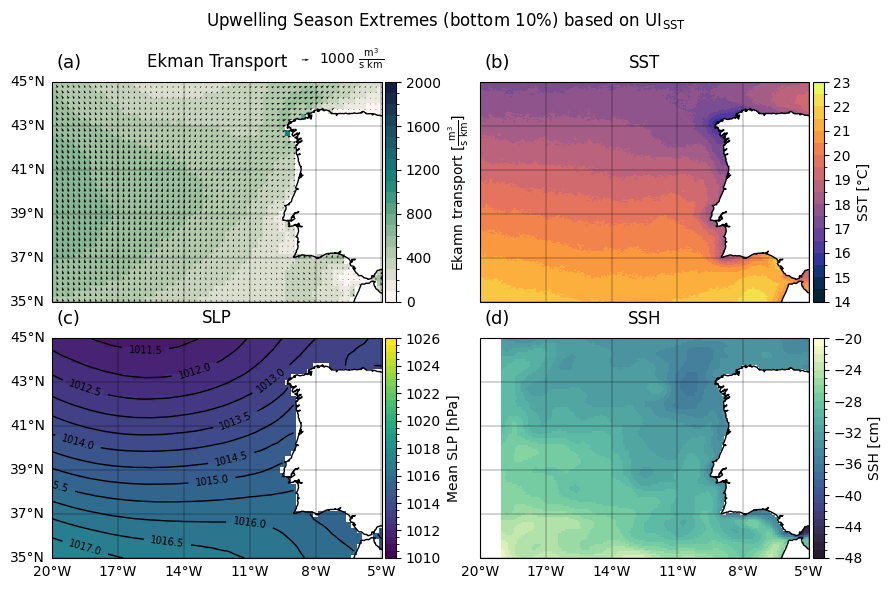

In [198]:
fig, ax = plt.subplots(2, 2, figsize = (9,6), subplot_kw={'projection': ccrs.PlateCarree()})
ax = ax.flatten()

# set up cartopy for all plots
for i in np.arange(4):
    ax[i].set_extent([-20.01, -4.99, 45.01, 34.99])
    ax[i].coastlines()
    gls = ax[i].gridlines(draw_labels=True, linewidth = 0.25, color = 'black')
    gls.top_labels = False 
    gls.right_labels = False
    gls.xlocator = mticker.FixedLocator(np.arange(-20, -4, 3))
    gls.ylocator = mticker.FixedLocator(np.arange(35, 46, 2))
    if i in (1, 3):
        gls.left_labels = False
    if i in (0, 1):
        gls.bottom_labels = False

#cp = Ek_comp_bottom_SST.magnitude.plot(ax = ax[0], add_colorbar = False, cmap = cmo.tempo, vmin = 0, vmax = 2000, alpha = 0.8, levels = np.arange(0, 2100, 100))
mag_bottom = np.hypot(Ek_comp_bottom_SST.ek_trans_u, Ek_comp_bottom_SST.ek_trans_v)
cmap = cmo.tempo
norm = mcolors.BoundaryNorm(np.arange(0, 2100, 100), ncolors = cmap.N, clip = True)
cp = ax[0].imshow(mag_bottom, origin = 'lower', extent=[-20, -5, 35, 45], norm = norm, cmap = cmap)
im = ax[0].quiver(Ek_comp_bottom_SST.lon, Ek_comp_bottom_SST.lat, Ek_comp_bottom_SST.ek_trans_u, Ek_comp_bottom_SST.ek_trans_v, angles='xy', scale_units='xy', scale = 3*1000) #, clim = [0,2*1000]) 
plt.colorbar(cp, ax = ax[0], label = r'Ekamn transport [$\frac{\rm m^3}{\rm s \ km}$]', fraction = 0.0319, pad = 0.01, ticks = np.arange(0, 2400, 400));
ax[0].set_title('Ekman Transport')
ax[0].text(-19.8, 45.65, '(a)', fontsize = 13)
ax[0].quiverkey(im, 0.78, 1.1, 1*1000, r'1000 $\frac{\rm m^3}{\rm s \ km}$', labelpos='E')

cp = SST_comp_bottom_SST.plot(ax = ax[1], add_colorbar = False, cmap = cmo.thermal, vmin = 14, vmax = 23, levels = np.arange(14, 23.5, 0.5))
plt.colorbar(cp, ax = ax[1], label = 'SST [°C]', fraction = 0.0319, pad = 0.01) 
ax[1].set_title('SST', pad = 10)
ax[1].text(-19.8, 45.65, '(b)', fontsize = 13)

cp = SLP_comp_bottom_SST.plot(ax = ax[2], add_colorbar = False, cmap = 'viridis', vmin = 1010, vmax = 1026, levels = np.arange(1010, 1026.5, 0.5))
clp = SLP_comp_bottom_SST.plot.contour(ax = ax[2], colors = 'black', linewidths = 1, levels = np.arange(1010, 1026.5, 0.5))
plt.colorbar(cp, ax = ax[2], label = 'Mean SLP [hPa]', fraction = 0.0319, pad = 0.01) 
plt.clabel(clp, fontsize = 7)
ax[2].set_title('SLP')
ax[2].text(-19.8, 45.65, '(c)', fontsize = 13)

cp = SSH_comp_bottom_SST.plot(ax = ax[3], add_colorbar = False, cmap = cmo.deep_r, vmin = -48, vmax = -22, levels = np.arange(-48, -19, 1))
cbar = plt.colorbar(cp, ax = ax[3], label = 'SSH [cm]', fraction = 0.0319, pad = 0.01, ticks = np.arange(-48, -16, 4))
#cbar.ax.locator_params(nbins = 4)
ax[3].set_title('SSH', pad = 10)
ax[3].text(-19.8, 45.65, '(d)', fontsize = 13)

fig.suptitle(r'Upwelling Season Extremes (bottom 10%) based on UI$_{\rm SST}$')
fig.tight_layout(pad=1, w_pad=0, h_pad=-0.8)
fig.savefig('Upwelling_Season_Extremes_bottom_SST.png', dpi = 300, bbox_inches = 'tight')

In [197]:
# min and max values overall 
print('Ek (combined) min:', Ek_comp_bottom_SST.magnitude.min().values, 'max: ', Ek_comp_bottom_SST.magnitude.max().values)
print('Ek (combined) min:', np.nanmin(mag_bottom.values), 'max: ', np.nanmax(mag_bottom.values))
print('SST min: ', SST_comp_bottom_SST.min().values, 'max: ', SST_comp_bottom_SST.max().values)
print('SLP min: ', SLP_comp_bottom_SST.min().values, 'max: ', SLP_comp_bottom_SST.max().values)
print('SSH min: ', SSH_comp_bottom_SST.min().values, 'max: ', SSH_comp_bottom_SST.max().values)

Ek (combined) min: 4.8083065356574375 max:  2160.191623606435
Ek (combined) min: 28.9950072111708 max:  1105.5687261576884
SST min:  14.799864864864862 max:  22.323648648648646
SLP min:  1011.3335 max:  1017.46356
SSH min:  -45.550895020694156 max:  -21.313393869474694


In [203]:
## combined
# find number and dates of weeks where both indices are extreme
extreme_weeks = [Ek_bottom_10_summer, SST_bottom_10_summer]
u, c = np.unique(extreme_weeks, return_counts = True)
dup_bottom = u[c > 1]
print('Number of weeks where extremes coincide:', len(dup_bottom), '\nTotal number of extremes per UI:', len(Ek_sub_summer))
dup_bottom

Number of weeks where extremes coincide: 17 
Total number of extremes per UI: 74


array(['1982-06-22T00:00:00.000000000', '1983-05-31T00:00:00.000000000',
       '1983-06-07T00:00:00.000000000', '1985-05-28T00:00:00.000000000',
       '1985-06-04T00:00:00.000000000', '1991-05-28T00:00:00.000000000',
       '1993-06-01T00:00:00.000000000', '1994-05-31T00:00:00.000000000',
       '1997-05-27T00:00:00.000000000', '1997-06-03T00:00:00.000000000',
       '1997-06-10T00:00:00.000000000', '1999-06-01T00:00:00.000000000',
       '2006-06-06T00:00:00.000000000', '2007-06-19T00:00:00.000000000',
       '2009-06-09T00:00:00.000000000', '2009-06-30T00:00:00.000000000',
       '2014-06-10T00:00:00.000000000'], dtype='datetime64[ns]')

In [204]:
Ek_comp_bottom = Ek_summer.sel(time = dup_bottom)[['ek_trans_u', 'ek_trans_v']].mean(dim = 'time') * 1000 # make it m3/s km
Ek_comp_bottom['magnitude'] = np.hypot(Ek_comp.ek_trans_u, Ek_comp.ek_trans_v) # doesn't work properly...
SST_comp_bottom = SST_summer.sel(time = dup_bottom).SST.mean(dim = 'time')
SLP_comp_bottom = SLP_summer.sel(time = dup_bottom).msl.where(SLP_summer.lsm).mean(dim = 'time') * 0.01 # make it hPa
SSH_comp_bottom = SSH_summer.sel(time = dup_bottom[np.where((dup_bottom > np.datetime64('1993-01-01')) & (dup_bottom < np.datetime64('2021-12-31')))]).zos.mean(dim = 'time') * 100 # make it cm

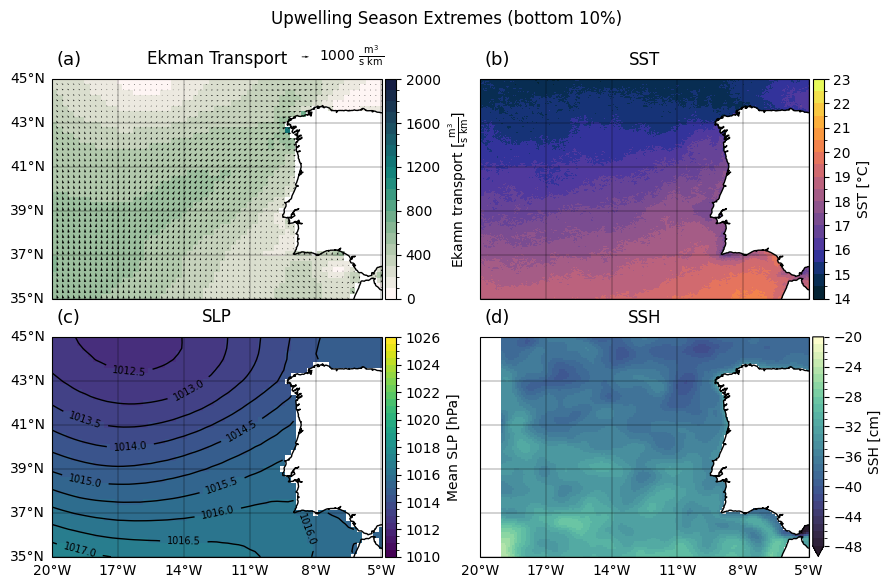

In [205]:
fig, ax = plt.subplots(2, 2, figsize = (9,6), subplot_kw={'projection': ccrs.PlateCarree()})
ax = ax.flatten()

# set up cartopy for all plots
for i in np.arange(4):
    ax[i].set_extent([-20.01, -4.99, 45.01, 34.99])
    ax[i].coastlines()
    gls = ax[i].gridlines(draw_labels=True, linewidth = 0.25, color = 'black')
    gls.top_labels = False 
    gls.right_labels = False
    gls.xlocator = mticker.FixedLocator(np.arange(-20, -4, 3))
    gls.ylocator = mticker.FixedLocator(np.arange(35, 46, 2))
    if i in (1, 3):
        gls.left_labels = False
    if i in (0, 1):
        gls.bottom_labels = False

#cp = Ek_comp_bottom.magnitude.plot(ax = ax[0], add_colorbar = False, cmap = cmo.tempo, vmin = 0, vmax = 2000, alpha = 0.8, levels = np.arange(0, 2100, 100))
mag_bottom = np.hypot(Ek_comp_bottom.ek_trans_u, Ek_comp_bottom.ek_trans_v)
cmap = cmo.tempo
norm = mcolors.BoundaryNorm(np.arange(0, 2100, 100), ncolors = cmap.N, clip = True)
cp = ax[0].imshow(mag_bottom, origin = 'lower', extent=[-20, -5, 35, 45], norm = norm, cmap = cmap)
im = ax[0].quiver(Ek_comp_bottom.lon, Ek_comp_bottom.lat, Ek_comp_bottom.ek_trans_u, Ek_comp_bottom.ek_trans_v, angles='xy', scale_units='xy', scale = 3*1000) #, clim = [0,2*1000]) 
plt.colorbar(cp, ax = ax[0], label = r'Ekamn transport [$\frac{\rm m^3}{\rm s \ km}$]', fraction = 0.0319, pad = 0.01, ticks = np.arange(0, 2400, 400));
ax[0].set_title('Ekman Transport')
ax[0].text(-19.8, 45.65, '(a)', fontsize = 13)
ax[0].quiverkey(im, 0.78, 1.1, 1*1000, r'1000 $\frac{\rm m^3}{\rm s \ km}$', labelpos='E')

cp = SST_comp_bottom.plot(ax = ax[1], add_colorbar = False, cmap = cmo.thermal, vmin = 14, vmax = 23, levels = np.arange(14, 23.5, 0.5))
plt.colorbar(cp, ax = ax[1], label = 'SST [°C]', fraction = 0.0319, pad = 0.01) 
ax[1].set_title('SST', pad = 10)
ax[1].text(-19.8, 45.65, '(b)', fontsize = 13)

cp = SLP_comp_bottom.plot(ax = ax[2], add_colorbar = False, cmap = 'viridis', vmin = 1010, vmax = 1026, levels = np.arange(1010, 1026.5, 0.5))
clp = SLP_comp_bottom.plot.contour(ax = ax[2], colors = 'black', linewidths = 1, levels = np.arange(1010, 1026.5, 0.5))
plt.colorbar(cp, ax = ax[2], label = 'Mean SLP [hPa]', fraction = 0.0319, pad = 0.01) 
plt.clabel(clp, fontsize = 7)
ax[2].set_title('SLP')
ax[2].text(-19.8, 45.65, '(c)', fontsize = 13)

cp = SSH_comp_bottom.plot(ax = ax[3], add_colorbar = False, cmap = cmo.deep_r, vmin = -48, vmax = -22, levels = np.arange(-48, -19, 1))
cbar = plt.colorbar(cp, ax = ax[3], label = 'SSH [cm]', fraction = 0.0319, pad = 0.01, ticks = np.arange(-48, -16, 4))
#cbar.ax.locator_params(nbins = 4)
ax[3].set_title('SSH', pad = 10)
ax[3].text(-19.8, 45.65, '(d)', fontsize = 13)

fig.suptitle('Upwelling Season Extremes (bottom 10%)')
fig.tight_layout(pad=1, w_pad=0, h_pad=-0.8)
fig.savefig('Upwelling_Season_Extremes_bottom.png', dpi = 300, bbox_inches = 'tight')

In [206]:
# min and max values overall 
print('Ek (combined) min:', Ek_comp_bottom.magnitude.min().values, 'max: ', Ek_comp_bottom.magnitude.max().values)
print('Ek (combined) min:', np.nanmin(mag_bottom.values), 'max: ', np.nanmax(mag_bottom.values))
print('SST min: ', SST_comp_bottom.min().values, 'max: ', SST_comp_bottom.max().values)
print('SLP min: ', SLP_comp_bottom.min().values, 'max: ', SLP_comp_bottom.max().values)
print('SSH min: ', SSH_comp_bottom.min().values, 'max: ', SSH_comp_bottom.max().values)

Ek (combined) min: 4.8083065356574375 max:  2160.191623606435
Ek (combined) min: 7.900620131026633 max:  1201.0242875503545
SST min:  14.338823529411764 max:  20.27588235294118
SLP min:  1012.2941 max:  1017.3781
SSH min:  -49.86363873203201 max:  -24.1545466018248


## More